<a href="https://colab.research.google.com/github/MohdDilshad-nitk/pytorch/blob/main/Transformer_with_validation_and_csv_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip '/content/processed_skeleton_data.zip'

Archive:  /content/processed_skeleton_data.zip
   creating: content/processed_skeleton_data/
  inflating: content/processed_skeleton_data/Person073_2.csv  
  inflating: content/processed_skeleton_data/Person085_4.csv  
  inflating: content/processed_skeleton_data/Person051_3.csv  
  inflating: content/processed_skeleton_data/Person062_4.csv  
  inflating: content/processed_skeleton_data/Person055_5.csv  
  inflating: content/processed_skeleton_data/Person115_4.csv  
  inflating: content/processed_skeleton_data/Person152_2.csv  
  inflating: content/processed_skeleton_data/Person119_1.csv  
  inflating: content/processed_skeleton_data/Person108_4.csv  
  inflating: content/processed_skeleton_data/Person018_1.csv  
  inflating: content/processed_skeleton_data/Person002_3.csv  
  inflating: content/processed_skeleton_data/Person062_2.csv  
  inflating: content/processed_skeleton_data/Person115_1.csv  
  inflating: content/processed_skeleton_data/Person073_4.csv  
  inflating: content/proc

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import random
import re

class SkeletonDataAugmenter:
    def __init__(self, processed_data_dir):
        """
        Initialize the skeleton data augmenter

        Args:
            processed_data_dir (str): Directory containing the processed CSV files
        """
        self.processed_data_dir = Path(processed_data_dir)
        self.metadata = pd.read_csv(self.processed_data_dir / 'metadata.csv')

    def normalize_to_range(self, sequence):
        """
        Normalize sequence to [0,1] range
        """
        min_vals = sequence.min()
        max_vals = sequence.max()
        normalized = (sequence - min_vals) / (max_vals - min_vals + 1e-7)
        return normalized

    def random_crop_sequence(self, sequence, min_frames=30):
        """Random continuous crop of sequence"""
        num_frames = len(sequence)
        if num_frames <= min_frames:
            return sequence

        crop_length = random.randint(min_frames, num_frames)
        start_idx = random.randint(0, num_frames - crop_length)
        return sequence.iloc[start_idx:start_idx + crop_length]

    def random_drop_frames(self, sequence, drop_ratio_range=(0.1, 0.3)):
        """Randomly drop and interpolate frames"""
        num_frames = len(sequence)
        drop_ratio = random.uniform(*drop_ratio_range)
        num_drops = int(num_frames * drop_ratio)

        if num_drops == 0:
            return sequence

        drop_indices = sorted(random.sample(range(num_frames), num_drops))
        sequence_dropped = sequence.drop(sequence.index[drop_indices])
        return sequence_dropped.interpolate(method='linear')

    def add_gaussian_noise(self, sequence, noise_level_range=(0.01, 0.03)):
        """Add random Gaussian noise to joint positions and normalize"""
        noise_level = random.uniform(*noise_level_range)
        noise = np.random.normal(0, noise_level, sequence.shape)
        noisy_sequence = pd.DataFrame(
            sequence.values + noise,
            columns=sequence.columns
        )
        return self.normalize_to_range(noisy_sequence)

    def scale_sequence(self, sequence, scale_range=(0.8, 1.2)):
        """Scale the joint positions"""
        scale = random.uniform(*scale_range)
        scaled = sequence * scale
        return self.normalize_to_range(scaled)

    def time_scale(self, sequence, scale_range=(0.8, 1.2)):
        """Scale the temporal dimension of the sequence"""
        scale = random.uniform(*scale_range)
        num_frames = len(sequence)
        new_num_frames = int(num_frames * scale)

        if new_num_frames < 3:  # Minimum frames for interpolation
            return sequence

        # Create new time points
        old_times = np.arange(num_frames)
        new_times = np.linspace(0, num_frames-1, new_num_frames)

        # Interpolate for each column
        scaled_data = np.zeros((new_num_frames, sequence.shape[1]))
        for i in range(sequence.shape[1]):
            scaled_data[:, i] = np.interp(new_times, old_times, sequence.iloc[:, i])

        return pd.DataFrame(scaled_data, columns=sequence.columns)

    def jitter_sequence(self, sequence, jitter_range=(0.98, 1.02)):
        """Add random jitter to each joint independently"""
        jitter_factors = np.random.uniform(
            jitter_range[0],
            jitter_range[1],
            size=sequence.shape
        )
        jittered = sequence * jitter_factors
        return self.normalize_to_range(jittered)

    def get_next_sequence_number(self, person_id):
        """Get the next available sequence number for a person"""
        pattern = f"{person_id}_(\\d+)\\.csv"
        existing_files = list(self.processed_data_dir.glob(f"{person_id}_*.csv"))

        max_num = 0
        for file in existing_files:
            match = re.match(pattern, file.name)
            if match:
                num = int(match.group(1))
                max_num = max(max_num, num)

        return max_num + 1

    def validate_sequence(self, sequence):
        """
        Validate that sequence contains no negative values
        """
        return not (sequence.values < 0).any()

    def generate_augmented_sequences(self, num_augmentations=10):
        """Generate augmented sequences with various strategies"""
        augmented_metadata = []

        # Define augmentation strategies
        strategies = [
            ('crop', lambda seq: self.random_crop_sequence(seq)),
            ('drop', lambda seq: self.random_drop_frames(seq)),
            ('noise', lambda seq: self.add_gaussian_noise(seq)),
            ('scale', lambda seq: self.scale_sequence(seq)),
            ('time_scale', lambda seq: self.time_scale(seq)),
            ('jitter', lambda seq: self.jitter_sequence(seq)),
            ('crop_noise', lambda seq: self.add_gaussian_noise(self.random_crop_sequence(seq))),
            ('scale_jitter', lambda seq: self.jitter_sequence(self.scale_sequence(seq))),
            ('time_noise', lambda seq: self.add_gaussian_noise(self.time_scale(seq))),
            ('drop_scale', lambda seq: self.scale_sequence(self.random_drop_frames(seq)))
        ]

        for _, row in self.metadata.iterrows():
            # Read original sequence
            original_file = self.processed_data_dir / row['file_name']
            original_sequence = pd.read_csv(original_file)
            person_id = row['person_id']

            aug_count = 0
            max_attempts = num_augmentations * 2  # Allow some failed attempts
            attempts = 0

            while aug_count < num_augmentations and attempts < max_attempts:
                attempts += 1

                # Choose random augmentation strategy
                strategy_name, strategy_func = random.choice(strategies)

                # Apply augmentation
                augmented = strategy_func(original_sequence)

                # Validate sequence
                if not self.validate_sequence(augmented):
                    continue

                # Get next sequence number
                next_seq_num = self.get_next_sequence_number(person_id)

                # Create filename with incremental number
                aug_filename = f"{person_id}_{next_seq_num:02d}.csv"
                aug_filepath = self.processed_data_dir / aug_filename

                # Save augmented sequence
                augmented.to_csv(aug_filepath, index=False)

                # Add to metadata
                augmented_metadata.append({
                    'person_id': person_id,
                    'sequence_id': f"{next_seq_num:02d}",
                    'file_name': aug_filename,
                    'num_frames': len(augmented),
                    'augmentation_type': strategy_name,
                    'original_sequence': row['file_name']
                })

                aug_count += 1

        # Update metadata file
        augmented_metadata_df = pd.DataFrame(augmented_metadata)
        original_metadata = pd.read_csv(self.processed_data_dir / 'metadata.csv')
        updated_metadata = pd.concat([original_metadata, augmented_metadata_df], ignore_index=True)
        updated_metadata.to_csv(self.processed_data_dir / 'metadata.csv', index=False)

def augment_skeleton_data(processed_data_dir, num_augmentations=10):
    """
    Convenience function to augment skeleton data

    Args:
        processed_data_dir (str): Directory containing processed CSV files
        num_augmentations (int): Number of augmentations per sequence
    """
    augmenter = SkeletonDataAugmenter(processed_data_dir)
    augmenter.generate_augmented_sequences(num_augmentations)

In [ ]:
# After running the original SkeletonDataProcessor
augment_skeleton_data(
    processed_data_dir="/content/content/processed_skeleton_data",
    num_augmentations=10
)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from pathlib import Path

class SkeletonDatasetFromCSV(Dataset):
    def __init__(self, data_dir, split_metadata_file):
        """
        Create a PyTorch dataset from processed CSV files for a specific split

        Args:
            data_dir (str): Directory containing processed CSV files and metadata
            split_metadata_file (str): Name of the split metadata file (e.g., 'train_metadata.csv')
        """
        self.data_dir = Path(data_dir)

        # Read split-specific metadata
        self.metadata = pd.read_csv(self.data_dir / split_metadata_file)

        # Create person ID mapping
        self.person_ids = sorted(self.metadata['person_id'].unique())
        self.person_to_idx = {pid: i for i, pid in enumerate(self.person_ids)}

        # Set max sequence length
        self.max_len = self.metadata['num_frames'].max()

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # Get metadata for this sequence
        row = self.metadata.iloc[idx]

        # Read sequence from CSV
        sequence_df = pd.read_csv(self.data_dir / row['file_name'])
        sequence = sequence_df.values

        # Reshape back to (frames, joints, 3)
        sequence = sequence.reshape(sequence.shape[0], -1, 3)

        # Convert to tensor
        sequence_tensor = torch.FloatTensor(sequence)

        # Pad sequence if necessary
        if sequence_tensor.size(0) < self.max_len:
            padding = torch.zeros(self.max_len - sequence_tensor.size(0),
                                sequence_tensor.size(1),
                                sequence_tensor.size(2))
            sequence_tensor = torch.cat([sequence_tensor, padding], dim=0)

        # Create attention mask
        attention_mask = torch.ones(self.max_len)
        attention_mask[sequence.shape[0]:] = 0

        return {
            'person_id': self.person_to_idx[row['person_id']],
            'sequence_id': row['sequence_id'],
            'sequence': sequence_tensor,
            'attention_mask': attention_mask
        }

# def create_fixed_splits(data_dir, batch_size=32):
#     """
#     Create train, validation, and test splits from processed CSV data
#     with fixed allocation: 3 for training, 1 for validation, 1 for testing

#     Args:
#         data_dir (str): Directory containing processed CSV files
#         batch_size (int): Batch size for data loaders

#     Returns:
#         tuple: Train, validation, and test data loaders
#     """
#     # Read metadata
#     metadata = pd.read_csv(Path(data_dir) / 'metadata.csv')

#     # Group by person_id
#     person_groups = metadata.groupby('person_id')

#     train_rows = []
#     val_rows = []
#     test_rows = []

#     for person_id, group in person_groups:
#         # Get all sequences for this person
#         sequences = group.sort_values('sequence_id')
#         n_sequences = len(sequences)

#         if n_sequences >= 5:
#             # Randomly select indices for val and test
#             available_idx = list(range(min(5, n_sequences)))
#             np.random.shuffle(available_idx)

#             val_idx = available_idx[0]
#             test_idx = available_idx[1]

#             # Assign to splits
#             val_rows.append(sequences.iloc[val_idx:val_idx+1])
#             test_rows.append(sequences.iloc[test_idx:test_idx+1])

#             # All remaining sequences (including those beyond index 5) go to training
#             train_indices = list(range(n_sequences))
#             train_indices.remove(val_idx)
#             train_indices.remove(test_idx)
#             train_rows.append(sequences.iloc[train_indices])

#         else:
#             # If less than 5 sequences, use the first 60% for training,
#             # 20% for validation, and 20% for testing
#             n_train = max(1, int(n_sequences * 0.6))
#             n_val = max(1, int(n_sequences * 0.2))

#             train_rows.append(sequences.iloc[:n_train])
#             if n_sequences > n_train:
#                 val_rows.append(sequences.iloc[n_train:n_train+n_val])
#             if n_sequences > n_train + n_val:
#                 test_rows.append(sequences.iloc[n_train+n_val:])

#     # Concatenate all rows
#     train_metadata = pd.concat(train_rows, ignore_index=True)
#     val_metadata = pd.concat(val_rows, ignore_index=True)
#     test_metadata = pd.concat(test_rows, ignore_index=True)

#     # Save split metadata
#     train_metadata.to_csv(Path(data_dir) / 'train_metadata.csv', index=False)
#     val_metadata.to_csv(Path(data_dir) / 'val_metadata.csv', index=False)
#     test_metadata.to_csv(Path(data_dir) / 'test_metadata.csv', index=False)

#     # Print distribution statistics
#     print("\nData split statistics:")
#     print(f"Total number of people: {len(person_groups)}")
#     print(f"Training samples: {len(train_metadata)}")
#     print(f"Validation samples: {len(val_metadata)}")
#     print(f"Test samples: {len(test_metadata)}")

#     # Create datasets
#     train_dataset = SkeletonDatasetFromCSV(data_dir, 'train_metadata.csv')
#     val_dataset = SkeletonDatasetFromCSV(data_dir, 'val_metadata.csv')
#     test_dataset = SkeletonDatasetFromCSV(data_dir, 'test_metadata.csv')

#     # Create data loaders
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size)

#     return train_loader, val_loader, test_loader

In [ ]:
def create_fixed_splits(data_dir, batch_size=32, seed=42):
    """
    Create train, validation, and test splits from processed CSV data
    with fixed allocation: 3 for training, 1 for validation, 1 for testing.
    Sequences are randomly shuffled before splitting.

    Args:
        data_dir (str): Directory containing processed CSV files
        batch_size (int): Batch size for data loaders
        seed (int): Random seed for reproducibility

    Returns:
        tuple: Train, validation, and test data loaders
    """
    # Set random seed for reproducibility
    np.random.seed(seed)

    # Read metadata
    metadata = pd.read_csv(Path(data_dir) / 'metadata.csv')

    # Group by person_id
    person_groups = metadata.groupby('person_id')

    train_rows = []
    val_rows = []
    test_rows = []

    for person_id, group in person_groups:
        # Get all sequences for this person and shuffle them
        sequences = group.sample(frac=1, random_state=seed).reset_index(drop=True)
        n_sequences = len(sequences)

        if n_sequences >= 5:
            # Take first sequence for validation, second for testing
            # and remaining (including any beyond 5) for training
            val_rows.append(sequences.iloc[0:1])
            test_rows.append(sequences.iloc[1:2])
            train_rows.append(sequences.iloc[2:])

        else:
            # If less than 5 sequences, use the first 60% for training,
            # 20% for validation, and 20% for testing
            n_train = max(1, int(n_sequences * 0.6))
            n_test = max(1, int(n_sequences * 0.2))

            train_rows.append(sequences.iloc[:n_train])
            if n_sequences > n_train:
                test_rows.append(sequences.iloc[n_train:n_train+n_test])
            if n_sequences > n_train + n_test:
                val_rows.append(sequences.iloc[n_train+n_test:])

    # Concatenate all rows
    train_metadata = pd.concat(train_rows, ignore_index=True)
    val_metadata = pd.concat(val_rows, ignore_index=True)
    test_metadata = pd.concat(test_rows, ignore_index=True)

    # Shuffle the final datasets again
    train_metadata = train_metadata.sample(frac=1, random_state=seed).reset_index(drop=True)
    val_metadata = val_metadata.sample(frac=1, random_state=seed).reset_index(drop=True)
    test_metadata = test_metadata.sample(frac=1, random_state=seed).reset_index(drop=True)

    # Save split metadata
    train_metadata.to_csv(Path(data_dir) / 'train_metadata.csv', index=False)
    val_metadata.to_csv(Path(data_dir) / 'val_metadata.csv', index=False)
    test_metadata.to_csv(Path(data_dir) / 'test_metadata.csv', index=False)

    # Print distribution statistics
    print("\nData split statistics:")
    print(f"Total number of people: {len(person_groups)}")
    print(f"Training samples: {len(train_metadata)}")
    print(f"Validation samples: {len(val_metadata)}")
    print(f"Test samples: {len(test_metadata)}")

    # Create datasets
    train_dataset = SkeletonDatasetFromCSV(data_dir, 'train_metadata.csv')
    val_dataset = SkeletonDatasetFromCSV(data_dir, 'val_metadata.csv')
    test_dataset = SkeletonDatasetFromCSV(data_dir, 'test_metadata.csv')

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

In [ ]:

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Directory containing the dataset
data_dir = "/content/content/processed_skeleton_data"
sb = ''
try:
    # Create data loaders
    train_loader, val_loader, test_loader = create_fixed_splits(data_dir=data_dir, batch_size=32)

    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(val_loader)}")
    print(f"Number of test batches: {len(test_loader)}")

    # Get a sample batch
    sample_batch = next(iter(train_loader))
    # print(sample_batch)
    print("\nSample batch contents:")
    for key, value in sample_batch.items():
        if torch.is_tensor(value):
            print(f"{key} shape: {value.shape}")
        else:
            print(f"{key}: {value}")

    # Save dataset statistics
    stats = {
        'num_training_sequences': len(train_loader.dataset),
        'num_validation_sequences': len(val_loader.dataset),
        'num_test_sequences': len(test_loader.dataset),
        'max_sequence_length': train_loader.dataset.max_len,
        'num_joints': 20,
        'num_persons': len(train_loader.dataset.person_ids)
    }

    pd.DataFrame([stats]).to_csv('dataset_statistics.csv', index=False)

except Exception as e:
    print(f"Error processing dataset: {str(e)}")



Data split statistics:
Total number of people: 164
Training samples: 494
Validation samples: 164
Test samples: 164
Number of training batches: 16
Number of validation batches: 6
Number of test batches: 6

Sample batch contents:
person_id shape: torch.Size([32])
sequence_id shape: torch.Size([32])
sequence shape: torch.Size([32, 1711, 20, 3])
attention_mask shape: torch.Size([32, 1711])


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import numpy as np
from typing import Dict, Tuple
# import wandb  # for logging
import random
import os
from datetime import datetime

# class TemporalAugmenter:
#     def __init__(
#         self,
#         crop_ratio_range=(0.8, 0.9),
#         mask_ratio_range=(0.1, 0.2),
#         min_sequence_length=16
#     ):
#         """
#         Initialize temporal augmentation parameters

#         Args:
#             crop_ratio_range (tuple): Range for random crop ratio
#             mask_ratio_range (tuple): Range for random masking ratio
#             min_sequence_length (int): Minimum sequence length after cropping
#         """
#         self.crop_ratio_range = crop_ratio_range
#         self.mask_ratio_range = mask_ratio_range
#         self.min_sequence_length = min_sequence_length

#     def random_temporal_crop(
#         self,
#         sequence: torch.Tensor,
#         attention_mask: torch.Tensor = None
#     ) -> Tuple[torch.Tensor, torch.Tensor]:
#         """Apply random temporal cropping to sequence"""
#         seq_length = sequence.size(1)

#         # Determine crop size
#         min_ratio, max_ratio = self.crop_ratio_range
#         crop_ratio = random.uniform(min_ratio, max_ratio)
#         crop_size = max(int(seq_length * crop_ratio), self.min_sequence_length)

#         # Random start point
#         max_start = seq_length - crop_size
#         start_idx = random.randint(0, max_start)
#         end_idx = start_idx + crop_size

#         # Apply crop
#         cropped_sequence = sequence[:, start_idx:end_idx]

#         if attention_mask is not None:
#             cropped_mask = attention_mask[:, start_idx:end_idx]
#             return cropped_sequence, cropped_mask

#         return cropped_sequence, None

#     def random_temporal_mask(
#         self,
#         sequence: torch.Tensor,
#         attention_mask: torch.Tensor = None
#     ) -> Tuple[torch.Tensor, torch.Tensor]:
#         """Apply random temporal masking to sequence"""
#         seq_length = sequence.size(1)

#         # Determine number of segments to mask
#         min_ratio, max_ratio = self.mask_ratio_range
#         mask_ratio = random.uniform(min_ratio, max_ratio)
#         num_masks = max(1, int(seq_length * mask_ratio))

#         # Create copy of sequence for masking
#         masked_sequence = sequence.clone()
#         if attention_mask is not None:
#             new_attention_mask = attention_mask.clone()

#         # Apply random masks
#         for _ in range(num_masks):
#             # Random mask length between 1 and 5 frames
#             mask_length = random.randint(1, min(5, seq_length // 10))
#             start_idx = random.randint(0, seq_length - mask_length)
#             end_idx = start_idx + mask_length

#             # Apply mask (set to zeros)
#             masked_sequence[:, start_idx:end_idx] = 0

#             if attention_mask is not None:
#                 new_attention_mask[:, start_idx:end_idx] = 0

#         if attention_mask is not None:
#             return masked_sequence, new_attention_mask

#         return masked_sequence, None



class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.pe[:, :x.size(1)]



class SkeletonEmbedding(nn.Module):
    """New approach: combine joints first, then embed"""
    def __init__(self, d_model: int):
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape: [batch_size, seq_len, num_joints, 3]
        batch_size, seq_len, num_joints, coords = x.shape

        # Combine all joints first
        x = x.reshape(batch_size, seq_len, num_joints * coords)  # [batch_size, seq_len, 60]

        # Project to d_model
        # x = self.joint_embedding(x)  # [batch_size, seq_len, d_model]  changing d_model to 60, no need to for a nn
        return x



In [ ]:
class SkeletonTransformer(nn.Module):
    def __init__(
        self,
        num_joints: int,
        d_model: int = 60,
        nhead: int = 8,
        num_encoder_layers: int = 6,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
        num_classes: int = None
    ):
        super().__init__()

        self.d_model = d_model
        self.embedding = SkeletonEmbedding(d_model)
        # print(self.embedding.shape)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers
        )


        # Classification head
        if num_classes is not None:
            self.classifier = nn.Linear(d_model, num_classes)
        else:
            self.classifier = None

    def encode(
        self,
        x: torch.Tensor,
        attention_mask: torch.Tensor = None
    ) -> torch.Tensor:
        # x shape: [batch_size, seq_len, num_joints, 3]
        x = self.embedding(x)  # [batch_size, seq_len, d_model]
        # print("embeddings shape: ", x.shape)
        x = self.pos_encoder(x)

        if attention_mask is not None:
            # Convert boolean mask to float attention mask
            attention_mask = attention_mask.float()
            attention_mask = attention_mask.masked_fill(
                attention_mask == 0,
                float('-inf')
            )

        encoded = self.transformer_encoder(x, src_key_padding_mask=attention_mask)
        # Use [CLS] token (first token) as sequence representation
        sequence_repr = encoded[:, 0]

        return sequence_repr

    def forward(
        self,
        x: torch.Tensor,
        attention_mask: torch.Tensor = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        sequence_repr = self.encode(x, attention_mask)
        # projection = self.projection(sequence_repr)  # ???

        if self.classifier is not None:
            logits = self.classifier(sequence_repr)
        else:
            logits = None

        return logits


In [ ]:
# class SkeletonTransformerTrainer:
#     def __init__(
#         self,
#         model: SkeletonTransformer,
#         train_loader: torch.utils.data.DataLoader,
#         val_loader: torch.utils.data.DataLoader,
#         learning_rate: float = 1e-3,
#         weight_decay: float = 1e-4,
#         # use_wandb: bool = False,
#         save_dir: str = 'models'
#     ):


#         self.model = model
#         self.train_loader = train_loader
#         self.val_loader = val_loader
#         self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#         self.model = self.model.to(self.device)
#         self.optimizer = Adam(
#             model.parameters(),
#             lr=learning_rate,
#             weight_decay=weight_decay
#         )

#         # self.contrastive_loss = NTXentLoss()
#         self.classification_loss = nn.CrossEntropyLoss()

#         self.save_dir = save_dir
#         os.makedirs(save_dir, exist_ok=True)

#         # self.augmenter = TemporalAugmenter()

#         # Initialize best metrics for model saving
#         self.best_val_accuracy = 0.0
#         self.best_epoch = 0

#     @torch.no_grad()
#     def validate(self) -> Dict[str, float]:
#         self.model.eval()
#         total_loss = 0
#         correct = 0
#         total = 0

#         for batch in self.val_loader:
#             sequence = batch['sequence'].to(self.device)
#             attention_mask = batch['attention_mask'].to(self.device)
#             person_id = batch['person_id'].to(self.device)

#             logits = self.model(sequence, attention_mask)
#             loss = self.classification_loss(logits, person_id)

#             total_loss += loss.item()
#             pred = logits.argmax(dim=1)
#             correct += (pred == person_id).sum().item()
#             total += person_id.size(0)

#         return {
#             'val_loss': total_loss / max(len(self.val_loader),1),
#             'val_accuracy': correct / max(total,1)
#         }

#     def augment_sequence(
#         self,
#         sequence: torch.Tensor,
#         attention_mask: torch.Tensor = None
#     ) -> Tuple[torch.Tensor, torch.Tensor]:
#         """Apply temporal augmentations to sequence"""
#         # First apply random crop
#         sequence, attention_mask = self.augmenter.random_temporal_crop(
#             sequence, attention_mask
#         )

#         # Then apply random masking
#         sequence, attention_mask = self.augmenter.random_temporal_mask(
#             sequence, attention_mask
#         )

#         return sequence, attention_mask

#     def save_checkpoint(
#         self,
#         epoch: int,
#         metrics: Dict[str, float],
#         is_best: bool = False
#     ):
#         """Save model checkpoint"""
#         timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

#         checkpoint = {
#             'epoch': epoch,
#             'model_state_dict': self.model.state_dict(),
#             'optimizer_state_dict': self.optimizer.state_dict(),
#             'metrics': metrics,
#             'best_val_accuracy': self.best_val_accuracy,
#             'best_epoch': self.best_epoch
#         }

#         # Save regular checkpoint
#         checkpoint_path = os.path.join(
#             self.save_dir,
#             f'checkpoint_epoch_{epoch}_{timestamp}.pt'
#         )
#         torch.save(checkpoint, checkpoint_path)

#         # Save best model if applicable
#         if is_best:
#             best_path = os.path.join(self.save_dir, 'best_model.pt')
#             torch.save(checkpoint, best_path)

#         # Optionally save model architecture config
#         if epoch == 0:
#             config = {
#                 'd_model': self.model.d_model,
#                 # 'nhead': self.model.transformer_encoder.layers[0].nhead,
#                 'num_encoder_layers': len(self.model.transformer_encoder.layers),
#                 'dim_feedforward': self.model.transformer_encoder.layers[0].linear1.out_features,
#             }
#             config_path = os.path.join(self.save_dir, 'model_config.pt')
#             torch.save(config, config_path)

#     def load_checkpoint(self, checkpoint_path: str):
#         """Load model checkpoint"""
#         checkpoint = torch.load(checkpoint_path)

#         self.model.load_state_dict(checkpoint['model_state_dict'])
#         self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#         self.best_val_accuracy = checkpoint['best_val_accuracy']
#         self.best_epoch = checkpoint['best_epoch']

#         return checkpoint['epoch']

#     def train_epoch(self) -> Dict[str, float]:
#         self.model.train()
#         total_cont_loss = 0
#         total_cls_loss = 0
#         correct = 0
#         total = 0


#         for batch in self.train_loader:
#             # Get batch data
#             sequence = batch['sequence'].to(self.device)
#             attention_mask = batch['attention_mask'].to(self.device)
#             person_id = batch['person_id'].to(self.device)

#             # print("before augmenting")


#             # Forward pass
#             logits1 = self.model(sequence, attention_mask)


#             # Calculate losses
#             #cont_loss = self.contrastive_loss(proj1, proj2)
#             cls_loss = self.classification_loss(logits1, person_id)


#             # print("cls_loss: ", cls_loss)

#             # Combined loss
#             loss =  cls_loss

#             # Backward pass
#             self.optimizer.zero_grad()
#             loss.backward()
#              # Add gradient clipping
#             # torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
#             self.optimizer.step()

#             # Statistics
#             #total_cont_loss += cont_loss.item()
#             total_cls_loss += cls_loss.item()

#             pred = logits1.argmax(dim=1)
#             correct += (pred == person_id).sum().item()
#             total += person_id.size(0)

#         return {
#             #'train_cont_loss': total_cont_loss / len(self.train_loader),
#             'train_cls_loss': total_cls_loss / len(self.train_loader),
#             'train_accuracy': correct / total
#         }

#     def train(self, num_epochs: int, resume_path: str = None):
#         # if self.use_wandb:
#         #     wandb.init(project='skeleton-transformer')

#         start_epoch = 0
#         if resume_path is not None:
#             start_epoch = self.load_checkpoint(resume_path)
#             print(f"Resumed training from epoch {start_epoch}")

#         for epoch in range(start_epoch, num_epochs):
#             print(f"Epoch {epoch+1}/{num_epochs}")

#             train_metrics = self.train_epoch()
#             val_metrics = self.validate()

#             metrics = {**train_metrics, **val_metrics}

#             # if epoch % 10 == 0:
#             for k, v in metrics.items():
#                 print(f"{k}: {v:.4f}")

#             # Check if this is the best model
#             is_best = False
#             if val_metrics['val_accuracy'] > self.best_val_accuracy:
#                 self.best_val_accuracy = val_metrics['val_accuracy']
#                 self.best_epoch = epoch
#                 is_best = True

#             # Save checkpoint
#             self.save_checkpoint(epoch, metrics, is_best)

#             # if self.use_wandb:
#             #     wandb.log(metrics)

#             print(f"Epoch {epoch+1}/{num_epochs}")
#             for k, v in metrics.items():
#                 print(f"{k}: {v:.4f}")
#             if is_best:
#                 print("New best model!")
#             print()


In [ ]:
from tqdm import tqdm

In [ ]:
class SkeletonTransformerTrainer:
    def __init__(
        self,
        model: SkeletonTransformer,
        train_loader: torch.utils.data.DataLoader,
        val_loader: torch.utils.data.DataLoader,
        learning_rate: float = 1e-3,
        weight_decay: float = 1e-4,
        save_dir: str = 'models'
    ):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.model = self.model.to(self.device)
        self.optimizer = Adam(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )

        self.classification_loss = nn.CrossEntropyLoss()
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)

        # Initialize best metrics for model saving
        self.best_val_accuracy = 0.0
        self.best_epoch = 0

    @torch.no_grad()
    def validate(self) -> Dict[str, float]:
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        # Add progress bar for validation
        val_pbar = tqdm(self.val_loader, desc='Validating', leave=False)

        for batch in val_pbar:
            sequence = batch['sequence'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            person_id = batch['person_id'].to(self.device)

            logits = self.model(sequence, attention_mask)
            loss = self.classification_loss(logits, person_id)

            total_loss += loss.item()
            pred = logits.argmax(dim=1)
            correct += (pred == person_id).sum().item()
            total += person_id.size(0)

            # Update progress bar with current accuracy
            current_accuracy = correct / max(total, 1)
            val_pbar.set_postfix({'accuracy': f'{current_accuracy:.4f}'})

        return {
            'val_loss': total_loss / max(len(self.val_loader), 1),
            'val_accuracy': correct / max(total, 1)
        }

    def augment_sequence(
        self,
        sequence: torch.Tensor,
        attention_mask: torch.Tensor = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Apply temporal augmentations to sequence"""
        # First apply random crop
        sequence, attention_mask = self.augmenter.random_temporal_crop(
            sequence, attention_mask
        )

        # Then apply random masking
        sequence, attention_mask = self.augmenter.random_temporal_mask(
            sequence, attention_mask
        )

        return sequence, attention_mask

    def save_checkpoint(
        self,
        epoch: int,
        metrics: Dict[str, float],
        is_best: bool = False
    ):
        """Save model checkpoint"""
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'metrics': metrics,
            'best_val_accuracy': self.best_val_accuracy,
            'best_epoch': self.best_epoch
        }

        checkpoint_path = os.path.join(
            self.save_dir,
            f'checkpoint_epoch_{epoch}_{timestamp}.pt'
        )
        torch.save(checkpoint, checkpoint_path)

        if is_best:
            best_path = os.path.join(self.save_dir, 'best_model.pt')
            torch.save(checkpoint, best_path)

        if epoch == 0:
            config = {
                'd_model': self.model.d_model,
                'num_encoder_layers': len(self.model.transformer_encoder.layers),
                'dim_feedforward': self.model.transformer_encoder.layers[0].linear1.out_features,
            }
            config_path = os.path.join(self.save_dir, 'model_config.pt')
            torch.save(config, config_path)

    def load_checkpoint(self, checkpoint_path: str):
        """Load model checkpoint"""
        checkpoint = torch.load(checkpoint_path)

        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.best_val_accuracy = checkpoint['best_val_accuracy']
        self.best_epoch = checkpoint['best_epoch']

        return checkpoint['epoch']

    def train_epoch(self) -> Dict[str, float]:
        self.model.train()
        total_cls_loss = 0
        correct = 0
        total = 0

        # Add progress bar for training batches
        train_pbar = tqdm(self.train_loader, desc='Training', leave=False)

        for batch in train_pbar:
            sequence = batch['sequence'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            person_id = batch['person_id'].to(self.device)

            logits1 = self.model(sequence, attention_mask)
            cls_loss = self.classification_loss(logits1, person_id)
            loss = cls_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_cls_loss += cls_loss.item()
            pred = logits1.argmax(dim=1)
            correct += (pred == person_id).sum().item()
            total += person_id.size(0)

            # Update progress bar with current loss and accuracy
            current_accuracy = correct / max(total, 1)
            train_pbar.set_postfix({
                'loss': f'{cls_loss.item():.4f}',
                'accuracy': f'{current_accuracy:.4f}'
            })

        return {
            'train_cls_loss': total_cls_loss / len(self.train_loader),
            'train_accuracy': correct / total
        }

    def train(self, num_epochs: int, resume_path: str = None):
        start_epoch = 0
        if resume_path is not None:
            start_epoch = self.load_checkpoint(resume_path)
            print(f"Resumed training from epoch {start_epoch}")

        # Add progress bar for epochs
        epoch_pbar = tqdm(range(start_epoch, num_epochs), desc='Training Progress', position=0)

        for epoch in epoch_pbar:
            train_metrics = self.train_epoch()
            val_metrics = self.validate()

            metrics = {**train_metrics, **val_metrics}

            # Update epoch progress bar with current metrics
            epoch_pbar.set_postfix({
                'train_acc': f"{train_metrics['train_accuracy']:.4f}",
                'val_acc': f"{val_metrics['val_accuracy']:.4f}"
            })

            # Check if this is the best model
            is_best = False
            if val_metrics['val_accuracy'] > self.best_val_accuracy:
                self.best_val_accuracy = val_metrics['val_accuracy']
                self.best_epoch = epoch
                is_best = True

            # Save checkpoint
            self.save_checkpoint(epoch, metrics, is_best)

            # Print detailed metrics every epoch
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            for k, v in metrics.items():
                print(f"{k}: {v:.4f}")
            if is_best:
                print("New best model!")
            print()

In [ ]:

# Create model and trainer
model = SkeletonTransformer(
    num_joints=20,
    d_model=60,
    nhead=1,
    num_encoder_layers=1,
    dim_feedforward=256,
    dropout=0.2,
    num_classes=164
)

trainer = SkeletonTransformerTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    save_dir='skeleton_transformer_models'
)



In [ ]:
!pip install tqdm

In [ ]:
# Train model
trainer.train(
    num_epochs=100,
    resume_path=None  # Set to checkpoint path to resume training
)

Training: 100%|██████████| 16/16 [00:06<00:00,  3.11it/s, loss=5.3658, accuracy=0.0061]
                                                                                       
Training Progress:   1%|          | 1/100 [00:08<13:14,  8.03s/it, train_acc=0.0061, val_acc=0.0122]


Epoch 1/100
train_cls_loss: 5.3459
train_accuracy: 0.0061
val_loss: 5.1745
val_accuracy: 0.0122
New best model!




Training: 100%|██████████| 16/16 [00:06<00:00,  2.72it/s, loss=5.3364, accuracy=0.0081]
                                                                                       
Training Progress:   2%|▏         | 2/100 [00:17<14:07,  8.65s/it, train_acc=0.0081, val_acc=0.0000]


Epoch 2/100
train_cls_loss: 5.1987
train_accuracy: 0.0081
val_loss: 5.1529
val_accuracy: 0.0000




Training: 100%|██████████| 16/16 [00:06<00:00,  3.15it/s, loss=5.1026, accuracy=0.0040]
                                                                                       
Training Progress:   3%|▎         | 3/100 [00:25<13:50,  8.56s/it, train_acc=0.0040, val_acc=0.0000]


Epoch 3/100
train_cls_loss: 5.1633
train_accuracy: 0.0040
val_loss: 5.1165
val_accuracy: 0.0000




Training: 100%|██████████| 16/16 [00:06<00:00,  3.11it/s, loss=5.2277, accuracy=0.0020]
                                                                                       
Training Progress:   4%|▍         | 4/100 [00:33<13:14,  8.27s/it, train_acc=0.0020, val_acc=0.0061]


Epoch 4/100
train_cls_loss: 5.1396
train_accuracy: 0.0020
val_loss: 5.1056
val_accuracy: 0.0061




Training: 100%|██████████| 16/16 [00:06<00:00,  2.78it/s, loss=5.1803, accuracy=0.0061]
                                                                                       
Training Progress:   5%|▌         | 5/100 [00:41<13:09,  8.31s/it, train_acc=0.0061, val_acc=0.0061]


Epoch 5/100
train_cls_loss: 5.1042
train_accuracy: 0.0061
val_loss: 5.0879
val_accuracy: 0.0061




Training: 100%|██████████| 16/16 [00:06<00:00,  3.07it/s, loss=5.0302, accuracy=0.0061]
                                                                                       
Training Progress:   6%|▌         | 6/100 [00:49<12:48,  8.18s/it, train_acc=0.0061, val_acc=0.0183]


Epoch 6/100
train_cls_loss: 5.0865
train_accuracy: 0.0061
val_loss: 5.0550
val_accuracy: 0.0183
New best model!




Training: 100%|██████████| 16/16 [00:06<00:00,  2.94it/s, loss=5.0146, accuracy=0.0101]
                                                                                       
Training Progress:   7%|▋         | 7/100 [00:58<12:47,  8.25s/it, train_acc=0.0101, val_acc=0.0183]


Epoch 7/100
train_cls_loss: 5.0375
train_accuracy: 0.0101
val_loss: 4.9947
val_accuracy: 0.0183




Training: 100%|██████████| 16/16 [00:06<00:00,  2.74it/s, loss=4.7097, accuracy=0.0223]
                                                                                       
Training Progress:   8%|▊         | 8/100 [01:06<12:43,  8.30s/it, train_acc=0.0223, val_acc=0.0183]


Epoch 8/100
train_cls_loss: 4.9363
train_accuracy: 0.0223
val_loss: 4.8839
val_accuracy: 0.0183




Training: 100%|██████████| 16/16 [00:06<00:00,  3.06it/s, loss=4.8419, accuracy=0.0182]
                                                                                       
Training Progress:   9%|▉         | 9/100 [01:14<12:22,  8.16s/it, train_acc=0.0182, val_acc=0.0305]


Epoch 9/100
train_cls_loss: 4.8277
train_accuracy: 0.0182
val_loss: 4.7708
val_accuracy: 0.0305
New best model!




Training: 100%|██████████| 16/16 [00:06<00:00,  3.08it/s, loss=4.8387, accuracy=0.0364]
                                                                                       
Training Progress:  10%|█         | 10/100 [01:22<12:24,  8.28s/it, train_acc=0.0364, val_acc=0.0427]


Epoch 10/100
train_cls_loss: 4.6929
train_accuracy: 0.0364
val_loss: 4.6941
val_accuracy: 0.0427
New best model!




Training: 100%|██████████| 16/16 [00:06<00:00,  2.53it/s, loss=4.5137, accuracy=0.0324]
                                                                                       
Training Progress:  11%|█         | 11/100 [01:31<12:20,  8.32s/it, train_acc=0.0324, val_acc=0.0427]


Epoch 11/100
train_cls_loss: 4.5809
train_accuracy: 0.0324
val_loss: 4.6108
val_accuracy: 0.0427




Training: 100%|██████████| 16/16 [00:06<00:00,  2.87it/s, loss=4.5042, accuracy=0.0486]
                                                                                       
Training Progress:  12%|█▏        | 12/100 [01:40<12:30,  8.53s/it, train_acc=0.0486, val_acc=0.0427]


Epoch 12/100
train_cls_loss: 4.4979
train_accuracy: 0.0486
val_loss: 4.5344
val_accuracy: 0.0427




Training: 100%|██████████| 16/16 [00:06<00:00,  3.04it/s, loss=4.1706, accuracy=0.0709]
                                                                                       
Training Progress:  13%|█▎        | 13/100 [01:48<12:11,  8.41s/it, train_acc=0.0709, val_acc=0.0488]


Epoch 13/100
train_cls_loss: 4.3904
train_accuracy: 0.0709
val_loss: 4.5030
val_accuracy: 0.0488
New best model!




Training: 100%|██████████| 16/16 [00:06<00:00,  2.69it/s, loss=4.5346, accuracy=0.0668]
                                                                                       
Training Progress:  14%|█▍        | 14/100 [01:57<12:08,  8.47s/it, train_acc=0.0668, val_acc=0.0488]


Epoch 14/100
train_cls_loss: 4.3333
train_accuracy: 0.0668
val_loss: 4.3959
val_accuracy: 0.0488




Training: 100%|██████████| 16/16 [00:06<00:00,  2.97it/s, loss=4.2911, accuracy=0.0749]
                                                                                       
Training Progress:  15%|█▌        | 15/100 [02:05<11:55,  8.41s/it, train_acc=0.0749, val_acc=0.0610]


Epoch 15/100
train_cls_loss: 4.2604
train_accuracy: 0.0749
val_loss: 4.3084
val_accuracy: 0.0610
New best model!




Training: 100%|██████████| 16/16 [00:06<00:00,  3.08it/s, loss=3.9345, accuracy=0.1012]
                                                                                       
Training Progress:  16%|█▌        | 16/100 [02:13<11:41,  8.35s/it, train_acc=0.1012, val_acc=0.0854]


Epoch 16/100
train_cls_loss: 4.1639
train_accuracy: 0.1012
val_loss: 4.2914
val_accuracy: 0.0854
New best model!




Training: 100%|██████████| 16/16 [00:06<00:00,  2.72it/s, loss=4.0521, accuracy=0.1073]
                                                                                       
Training Progress:  17%|█▋        | 17/100 [02:22<11:37,  8.40s/it, train_acc=0.1073, val_acc=0.0671]


Epoch 17/100
train_cls_loss: 4.0888
train_accuracy: 0.1073
val_loss: 4.2191
val_accuracy: 0.0671




Training: 100%|██████████| 16/16 [00:06<00:00,  3.07it/s, loss=3.9945, accuracy=0.1275]
                                                                                       
Training Progress:  18%|█▊        | 18/100 [02:29<11:15,  8.24s/it, train_acc=0.1275, val_acc=0.0976]


Epoch 18/100
train_cls_loss: 3.9818
train_accuracy: 0.1275
val_loss: 4.1721
val_accuracy: 0.0976
New best model!




Training: 100%|██████████| 16/16 [00:06<00:00,  2.84it/s, loss=3.6564, accuracy=0.1275]
                                                                                       
Training Progress:  19%|█▉        | 19/100 [02:38<11:12,  8.30s/it, train_acc=0.1275, val_acc=0.0854]


Epoch 19/100
train_cls_loss: 3.9090
train_accuracy: 0.1275
val_loss: 4.0988
val_accuracy: 0.0854




Training: 100%|██████████| 16/16 [00:06<00:00,  2.53it/s, loss=4.0032, accuracy=0.1538]
                                                                                       
Training Progress:  20%|██        | 20/100 [02:46<11:07,  8.34s/it, train_acc=0.1538, val_acc=0.1280]


Epoch 20/100
train_cls_loss: 3.8278
train_accuracy: 0.1538
val_loss: 4.0626
val_accuracy: 0.1280
New best model!




Training: 100%|██████████| 16/16 [00:06<00:00,  2.92it/s, loss=3.6833, accuracy=0.1538]
                                                                                       
Training Progress:  21%|██        | 21/100 [02:54<10:47,  8.19s/it, train_acc=0.1538, val_acc=0.1463]


Epoch 21/100
train_cls_loss: 3.7497
train_accuracy: 0.1538
val_loss: 4.0013
val_accuracy: 0.1463
New best model!




Training: 100%|██████████| 16/16 [00:06<00:00,  3.05it/s, loss=3.5178, accuracy=0.1923]
                                                                                       
Training Progress:  22%|██▏       | 22/100 [03:03<10:44,  8.27s/it, train_acc=0.1923, val_acc=0.1280]


Epoch 22/100
train_cls_loss: 3.6486
train_accuracy: 0.1923
val_loss: 3.9759
val_accuracy: 0.1280




Training: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s, loss=3.6769, accuracy=0.1964]
                                                                                       
Training Progress:  23%|██▎       | 23/100 [03:11<10:41,  8.33s/it, train_acc=0.1964, val_acc=0.1524]


Epoch 23/100
train_cls_loss: 3.6166
train_accuracy: 0.1964
val_loss: 3.9177
val_accuracy: 0.1524
New best model!




Training: 100%|██████████| 16/16 [00:05<00:00,  3.07it/s, loss=3.6529, accuracy=0.2085]
                                                                                       
Training Progress:  24%|██▍       | 24/100 [03:19<10:18,  8.13s/it, train_acc=0.2085, val_acc=0.1524]


Epoch 24/100
train_cls_loss: 3.5404
train_accuracy: 0.2085
val_loss: 3.8557
val_accuracy: 0.1524




Training: 100%|██████████| 16/16 [00:06<00:00,  3.02it/s, loss=3.0315, accuracy=0.2146]
                                                                                       
Training Progress:  25%|██▌       | 25/100 [03:27<10:19,  8.26s/it, train_acc=0.2146, val_acc=0.1646]


Epoch 25/100
train_cls_loss: 3.4830
train_accuracy: 0.2146
val_loss: 3.9052
val_accuracy: 0.1646
New best model!




Training: 100%|██████████| 16/16 [00:06<00:00,  2.24it/s, loss=3.1521, accuracy=0.2024]
                                                                                       
Training Progress:  26%|██▌       | 26/100 [03:36<10:16,  8.33s/it, train_acc=0.2024, val_acc=0.1646]


Epoch 26/100
train_cls_loss: 3.3842
train_accuracy: 0.2024
val_loss: 3.8339
val_accuracy: 0.1646




Training: 100%|██████████| 16/16 [00:06<00:00,  2.88it/s, loss=2.8697, accuracy=0.2571]
                                                                                       
Training Progress:  27%|██▋       | 27/100 [03:44<10:01,  8.24s/it, train_acc=0.2571, val_acc=0.1768]


Epoch 27/100
train_cls_loss: 3.3419
train_accuracy: 0.2571
val_loss: 3.7933
val_accuracy: 0.1768
New best model!




Training: 100%|██████████| 16/16 [00:06<00:00,  2.99it/s, loss=3.5517, accuracy=0.2287]
                                                                                       
Training Progress:  28%|██▊       | 28/100 [03:52<10:00,  8.33s/it, train_acc=0.2287, val_acc=0.1280]


Epoch 28/100
train_cls_loss: 3.2907
train_accuracy: 0.2287
val_loss: 3.7772
val_accuracy: 0.1280




Training: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s, loss=3.5983, accuracy=0.2571]
                                                                                       
Training Progress:  29%|██▉       | 29/100 [04:01<09:57,  8.42s/it, train_acc=0.2571, val_acc=0.1768]


Epoch 29/100
train_cls_loss: 3.2924
train_accuracy: 0.2571
val_loss: 3.7528
val_accuracy: 0.1768




Training: 100%|██████████| 16/16 [00:06<00:00,  3.02it/s, loss=3.1946, accuracy=0.2591]
                                                                                       
Training Progress:  30%|███       | 30/100 [04:09<09:36,  8.24s/it, train_acc=0.2591, val_acc=0.1768]


Epoch 30/100
train_cls_loss: 3.1957
train_accuracy: 0.2591
val_loss: 3.7850
val_accuracy: 0.1768




Training: 100%|██████████| 16/16 [00:07<00:00,  2.86it/s, loss=3.3899, accuracy=0.2733]
                                                                                       
Training Progress:  31%|███       | 31/100 [04:18<09:38,  8.39s/it, train_acc=0.2733, val_acc=0.2317]


Epoch 31/100
train_cls_loss: 3.1481
train_accuracy: 0.2733
val_loss: 3.7030
val_accuracy: 0.2317
New best model!




Training: 100%|██████████| 16/16 [00:07<00:00,  2.26it/s, loss=3.8487, accuracy=0.3097]
                                                                                       
Training Progress:  32%|███▏      | 32/100 [04:26<09:39,  8.53s/it, train_acc=0.3097, val_acc=0.2317]


Epoch 32/100
train_cls_loss: 3.0659
train_accuracy: 0.3097
val_loss: 3.6801
val_accuracy: 0.2317




Training: 100%|██████████| 16/16 [00:06<00:00,  2.96it/s, loss=2.9041, accuracy=0.2692]
                                                                                       
Training Progress:  33%|███▎      | 33/100 [04:34<09:20,  8.37s/it, train_acc=0.2692, val_acc=0.2439]


Epoch 33/100
train_cls_loss: 2.9876
train_accuracy: 0.2692
val_loss: 3.6396
val_accuracy: 0.2439
New best model!




Training: 100%|██████████| 16/16 [00:07<00:00,  2.92it/s, loss=3.0262, accuracy=0.3016]
                                                                                       
Training Progress:  34%|███▍      | 34/100 [04:44<09:33,  8.69s/it, train_acc=0.3016, val_acc=0.2378]


Epoch 34/100
train_cls_loss: 2.9767
train_accuracy: 0.3016
val_loss: 3.6630
val_accuracy: 0.2378




Training: 100%|██████████| 16/16 [00:07<00:00,  2.57it/s, loss=3.8571, accuracy=0.2996]
                                                                                       
Training Progress:  35%|███▌      | 35/100 [04:53<09:26,  8.71s/it, train_acc=0.2996, val_acc=0.2378]


Epoch 35/100
train_cls_loss: 2.9549
train_accuracy: 0.2996
val_loss: 3.6475
val_accuracy: 0.2378




Training: 100%|██████████| 16/16 [00:06<00:00,  2.97it/s, loss=3.0085, accuracy=0.3583]
                                                                                       
Training Progress:  36%|███▌      | 36/100 [05:01<09:06,  8.53s/it, train_acc=0.3583, val_acc=0.2073]


Epoch 36/100
train_cls_loss: 2.8600
train_accuracy: 0.3583
val_loss: 3.6083
val_accuracy: 0.2073




Training: 100%|██████████| 16/16 [00:06<00:00,  3.02it/s, loss=3.1997, accuracy=0.3300]
                                                                                       
Training Progress:  37%|███▋      | 37/100 [05:09<08:54,  8.49s/it, train_acc=0.3300, val_acc=0.2073]


Epoch 37/100
train_cls_loss: 2.8170
train_accuracy: 0.3300
val_loss: 3.5831
val_accuracy: 0.2073




Training: 100%|██████████| 16/16 [00:06<00:00,  2.60it/s, loss=2.9342, accuracy=0.3462]
                                                                                       
Training Progress:  38%|███▊      | 38/100 [05:18<08:48,  8.52s/it, train_acc=0.3462, val_acc=0.2073]


Epoch 38/100
train_cls_loss: 2.7517
train_accuracy: 0.3462
val_loss: 3.6669
val_accuracy: 0.2073




Training: 100%|██████████| 16/16 [00:06<00:00,  2.94it/s, loss=2.3476, accuracy=0.3603]
                                                                                       
Training Progress:  39%|███▉      | 39/100 [05:26<08:30,  8.37s/it, train_acc=0.3603, val_acc=0.2134]


Epoch 39/100
train_cls_loss: 2.7135
train_accuracy: 0.3603
val_loss: 3.5937
val_accuracy: 0.2134




Training: 100%|██████████| 16/16 [00:06<00:00,  3.04it/s, loss=3.2826, accuracy=0.3785]
                                                                                       
Training Progress:  40%|████      | 40/100 [05:34<08:24,  8.41s/it, train_acc=0.3785, val_acc=0.2134]


Epoch 40/100
train_cls_loss: 2.7017
train_accuracy: 0.3785
val_loss: 3.5412
val_accuracy: 0.2134




Training: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s, loss=2.5591, accuracy=0.3785]
                                                                                       
Training Progress:  41%|████      | 41/100 [05:43<08:17,  8.43s/it, train_acc=0.3785, val_acc=0.2256]


Epoch 41/100
train_cls_loss: 2.5954
train_accuracy: 0.3785
val_loss: 3.5736
val_accuracy: 0.2256




Training: 100%|██████████| 16/16 [00:06<00:00,  2.94it/s, loss=2.3285, accuracy=0.4008]
                                                                                       
Training Progress:  42%|████▏     | 42/100 [05:50<07:57,  8.24s/it, train_acc=0.4008, val_acc=0.2317]


Epoch 42/100
train_cls_loss: 2.5488
train_accuracy: 0.4008
val_loss: 3.5379
val_accuracy: 0.2317




Training: 100%|██████████| 16/16 [00:06<00:00,  2.92it/s, loss=2.7176, accuracy=0.3907]
                                                                                       
Training Progress:  43%|████▎     | 43/100 [05:59<07:56,  8.36s/it, train_acc=0.3907, val_acc=0.2744]


Epoch 43/100
train_cls_loss: 2.5164
train_accuracy: 0.3907
val_loss: 3.4629
val_accuracy: 0.2744
New best model!




Training: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s, loss=2.7797, accuracy=0.4109]
                                                                                       
Training Progress:  44%|████▍     | 44/100 [06:08<07:50,  8.40s/it, train_acc=0.4109, val_acc=0.2195]


Epoch 44/100
train_cls_loss: 2.4280
train_accuracy: 0.4109
val_loss: 3.4797
val_accuracy: 0.2195




Training: 100%|██████████| 16/16 [00:06<00:00,  2.93it/s, loss=2.4683, accuracy=0.4433]
                                                                                       
Training Progress:  45%|████▌     | 45/100 [06:16<07:34,  8.26s/it, train_acc=0.4433, val_acc=0.2378]


Epoch 45/100
train_cls_loss: 2.3759
train_accuracy: 0.4433
val_loss: 3.4510
val_accuracy: 0.2378




Training: 100%|██████████| 16/16 [00:06<00:00,  3.01it/s, loss=2.2898, accuracy=0.4372]
                                                                                       
Training Progress:  46%|████▌     | 46/100 [06:24<07:30,  8.34s/it, train_acc=0.4372, val_acc=0.2439]


Epoch 46/100
train_cls_loss: 2.3745
train_accuracy: 0.4372
val_loss: 3.4455
val_accuracy: 0.2439




Training: 100%|██████████| 16/16 [00:06<00:00,  2.26it/s, loss=2.5691, accuracy=0.4190]
                                                                                       
Training Progress:  47%|████▋     | 47/100 [06:33<07:27,  8.45s/it, train_acc=0.4190, val_acc=0.2134]


Epoch 47/100
train_cls_loss: 2.3213
train_accuracy: 0.4190
val_loss: 3.5131
val_accuracy: 0.2134




Training: 100%|██████████| 16/16 [00:06<00:00,  2.91it/s, loss=2.1371, accuracy=0.4089]
                                                                                       
Training Progress:  48%|████▊     | 48/100 [06:41<07:11,  8.30s/it, train_acc=0.4089, val_acc=0.2378]


Epoch 48/100
train_cls_loss: 2.3308
train_accuracy: 0.4089
val_loss: 3.4548
val_accuracy: 0.2378




Training: 100%|██████████| 16/16 [00:06<00:00,  2.97it/s, loss=1.9797, accuracy=0.4818]
                                                                                       
Training Progress:  49%|████▉     | 49/100 [06:49<07:07,  8.39s/it, train_acc=0.4818, val_acc=0.2744]


Epoch 49/100
train_cls_loss: 2.1661
train_accuracy: 0.4818
val_loss: 3.4025
val_accuracy: 0.2744




Training: 100%|██████████| 16/16 [00:06<00:00,  2.31it/s, loss=2.4439, accuracy=0.4858]
                                                                                       
Training Progress:  50%|█████     | 50/100 [06:58<07:02,  8.45s/it, train_acc=0.4858, val_acc=0.2622]


Epoch 50/100
train_cls_loss: 2.1499
train_accuracy: 0.4858
val_loss: 3.3947
val_accuracy: 0.2622




Training: 100%|██████████| 16/16 [00:06<00:00,  2.93it/s, loss=1.6824, accuracy=0.4798]
                                                                                       
Training Progress:  51%|█████     | 51/100 [07:06<06:46,  8.30s/it, train_acc=0.4798, val_acc=0.2744]


Epoch 51/100
train_cls_loss: 2.0916
train_accuracy: 0.4798
val_loss: 3.4027
val_accuracy: 0.2744




Training: 100%|██████████| 16/16 [00:06<00:00,  2.93it/s, loss=2.1063, accuracy=0.5101]
                                                                                       
Training Progress:  52%|█████▏    | 52/100 [07:15<06:43,  8.40s/it, train_acc=0.5101, val_acc=0.2805]


Epoch 52/100
train_cls_loss: 2.0688
train_accuracy: 0.5101
val_loss: 3.3966
val_accuracy: 0.2805
New best model!




Training: 100%|██████████| 16/16 [00:06<00:00,  2.30it/s, loss=2.1641, accuracy=0.5142]
                                                                                       
Training Progress:  53%|█████▎    | 53/100 [07:23<06:40,  8.51s/it, train_acc=0.5142, val_acc=0.2683]


Epoch 53/100
train_cls_loss: 1.9972
train_accuracy: 0.5142
val_loss: 3.3809
val_accuracy: 0.2683




Training: 100%|██████████| 16/16 [00:06<00:00,  2.91it/s, loss=1.7488, accuracy=0.5243]
                                                                                       
Training Progress:  54%|█████▍    | 54/100 [07:31<06:22,  8.33s/it, train_acc=0.5243, val_acc=0.2561]


Epoch 54/100
train_cls_loss: 1.9609
train_accuracy: 0.5243
val_loss: 3.3834
val_accuracy: 0.2561




Training: 100%|██████████| 16/16 [00:06<00:00,  2.93it/s, loss=1.9093, accuracy=0.4899]
                                                                                       
Training Progress:  55%|█████▌    | 55/100 [07:40<06:19,  8.43s/it, train_acc=0.4899, val_acc=0.2744]


Epoch 55/100
train_cls_loss: 1.9459
train_accuracy: 0.4899
val_loss: 3.5204
val_accuracy: 0.2744




Training: 100%|██████████| 16/16 [00:07<00:00,  2.05it/s, loss=2.1551, accuracy=0.5121]
                                                                                       
Training Progress:  56%|█████▌    | 56/100 [07:49<06:24,  8.75s/it, train_acc=0.5121, val_acc=0.3110]


Epoch 56/100
train_cls_loss: 1.9859
train_accuracy: 0.5121
val_loss: 3.3568
val_accuracy: 0.3110
New best model!




Training: 100%|██████████| 16/16 [00:06<00:00,  2.96it/s, loss=2.2014, accuracy=0.5526]
                                                                                       
Training Progress:  57%|█████▋    | 57/100 [07:57<06:06,  8.53s/it, train_acc=0.5526, val_acc=0.3110]


Epoch 57/100
train_cls_loss: 1.8691
train_accuracy: 0.5526
val_loss: 3.2990
val_accuracy: 0.3110




Training: 100%|██████████| 16/16 [00:06<00:00,  2.93it/s, loss=2.2238, accuracy=0.5202]
                                                                                       
Training Progress:  58%|█████▊    | 58/100 [08:06<05:59,  8.55s/it, train_acc=0.5202, val_acc=0.2683]


Epoch 58/100
train_cls_loss: 1.8782
train_accuracy: 0.5202
val_loss: 3.3795
val_accuracy: 0.2683




Training: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s, loss=1.7306, accuracy=0.5466]
                                                                                       
Training Progress:  59%|█████▉    | 59/100 [08:15<05:52,  8.59s/it, train_acc=0.5466, val_acc=0.2317]


Epoch 59/100
train_cls_loss: 1.8373
train_accuracy: 0.5466
val_loss: 3.4096
val_accuracy: 0.2317




Training: 100%|██████████| 16/16 [00:06<00:00,  2.97it/s, loss=1.6557, accuracy=0.5020]
                                                                                       
Training Progress:  60%|██████    | 60/100 [08:23<05:36,  8.41s/it, train_acc=0.5020, val_acc=0.2988]


Epoch 60/100
train_cls_loss: 1.8691
train_accuracy: 0.5020
val_loss: 3.3791
val_accuracy: 0.2988




Training: 100%|██████████| 16/16 [00:06<00:00,  3.00it/s, loss=1.9477, accuracy=0.5243]
                                                                                       
Training Progress:  61%|██████    | 61/100 [08:31<05:30,  8.48s/it, train_acc=0.5243, val_acc=0.3110]


Epoch 61/100
train_cls_loss: 1.8092
train_accuracy: 0.5243
val_loss: 3.3604
val_accuracy: 0.3110




Training: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s, loss=1.4431, accuracy=0.5486]
                                                                                       
Training Progress:  62%|██████▏   | 62/100 [08:40<05:24,  8.54s/it, train_acc=0.5486, val_acc=0.3354]


Epoch 62/100
train_cls_loss: 1.7410
train_accuracy: 0.5486
val_loss: 3.2471
val_accuracy: 0.3354
New best model!




Training: 100%|██████████| 16/16 [00:06<00:00,  3.00it/s, loss=1.5588, accuracy=0.6194]
                                                                                       
Training Progress:  63%|██████▎   | 63/100 [08:48<05:08,  8.33s/it, train_acc=0.6194, val_acc=0.3110]


Epoch 63/100
train_cls_loss: 1.6031
train_accuracy: 0.6194
val_loss: 3.2864
val_accuracy: 0.3110




Training: 100%|██████████| 16/16 [00:07<00:00,  2.88it/s, loss=1.8856, accuracy=0.5769]
                                                                                       
Training Progress:  64%|██████▍   | 64/100 [08:57<05:05,  8.48s/it, train_acc=0.5769, val_acc=0.3232]


Epoch 64/100
train_cls_loss: 1.6660
train_accuracy: 0.5769
val_loss: 3.2970
val_accuracy: 0.3232




Training: 100%|██████████| 16/16 [00:06<00:00,  2.26it/s, loss=1.8404, accuracy=0.6053]
                                                                                       
Training Progress:  65%|██████▌   | 65/100 [09:05<05:00,  8.59s/it, train_acc=0.6053, val_acc=0.3537]


Epoch 65/100
train_cls_loss: 1.6130
train_accuracy: 0.6053
val_loss: 3.2415
val_accuracy: 0.3537
New best model!




Training: 100%|██████████| 16/16 [00:06<00:00,  2.86it/s, loss=1.3606, accuracy=0.6316]
                                                                                       
Training Progress:  66%|██████▌   | 66/100 [09:13<04:46,  8.42s/it, train_acc=0.6316, val_acc=0.2988]


Epoch 66/100
train_cls_loss: 1.5370
train_accuracy: 0.6316
val_loss: 3.3785
val_accuracy: 0.2988




Training: 100%|██████████| 16/16 [00:06<00:00,  3.02it/s, loss=1.6830, accuracy=0.6336]
                                                                                       
Training Progress:  67%|██████▋   | 67/100 [09:22<04:40,  8.49s/it, train_acc=0.6336, val_acc=0.2927]


Epoch 67/100
train_cls_loss: 1.4714
train_accuracy: 0.6336
val_loss: 3.3112
val_accuracy: 0.2927




Training: 100%|██████████| 16/16 [00:06<00:00,  2.24it/s, loss=1.6111, accuracy=0.6174]
                                                                                       
Training Progress:  68%|██████▊   | 68/100 [09:31<04:35,  8.60s/it, train_acc=0.6174, val_acc=0.3476]


Epoch 68/100
train_cls_loss: 1.5338
train_accuracy: 0.6174
val_loss: 3.2939
val_accuracy: 0.3476




Training: 100%|██████████| 16/16 [00:06<00:00,  3.01it/s, loss=1.8562, accuracy=0.6518]
                                                                                       
Training Progress:  69%|██████▉   | 69/100 [09:39<04:20,  8.39s/it, train_acc=0.6518, val_acc=0.3476]


Epoch 69/100
train_cls_loss: 1.4110
train_accuracy: 0.6518
val_loss: 3.2350
val_accuracy: 0.3476




Training: 100%|██████████| 16/16 [00:07<00:00,  2.79it/s, loss=1.7818, accuracy=0.6417]
                                                                                       
Training Progress:  70%|███████   | 70/100 [09:48<04:14,  8.50s/it, train_acc=0.6417, val_acc=0.3354]


Epoch 70/100
train_cls_loss: 1.5054
train_accuracy: 0.6417
val_loss: 3.2457
val_accuracy: 0.3354




Training: 100%|██████████| 16/16 [00:06<00:00,  2.28it/s, loss=1.5350, accuracy=0.6316]
                                                                                       
Training Progress:  71%|███████   | 71/100 [09:56<04:09,  8.59s/it, train_acc=0.6316, val_acc=0.3537]


Epoch 71/100
train_cls_loss: 1.4232
train_accuracy: 0.6316
val_loss: 3.2946
val_accuracy: 0.3537




Training: 100%|██████████| 16/16 [00:06<00:00,  2.86it/s, loss=1.5243, accuracy=0.6538]
                                                                                       
Training Progress:  72%|███████▏  | 72/100 [10:05<03:56,  8.43s/it, train_acc=0.6538, val_acc=0.3049]


Epoch 72/100
train_cls_loss: 1.3749
train_accuracy: 0.6538
val_loss: 3.2571
val_accuracy: 0.3049




Training: 100%|██████████| 16/16 [00:06<00:00,  2.96it/s, loss=1.3230, accuracy=0.6437]
                                                                                       
Training Progress:  73%|███████▎  | 73/100 [10:13<03:49,  8.51s/it, train_acc=0.6437, val_acc=0.3293]


Epoch 73/100
train_cls_loss: 1.4096
train_accuracy: 0.6437
val_loss: 3.1724
val_accuracy: 0.3293




Training: 100%|██████████| 16/16 [00:06<00:00,  2.28it/s, loss=1.4449, accuracy=0.6478]
                                                                                       
Training Progress:  74%|███████▍  | 74/100 [10:22<03:43,  8.59s/it, train_acc=0.6478, val_acc=0.3110]


Epoch 74/100
train_cls_loss: 1.3624
train_accuracy: 0.6478
val_loss: 3.3120
val_accuracy: 0.3110




Training: 100%|██████████| 16/16 [00:06<00:00,  3.00it/s, loss=1.3729, accuracy=0.6761]
                                                                                       
Training Progress:  75%|███████▌  | 75/100 [10:30<03:30,  8.43s/it, train_acc=0.6761, val_acc=0.3232]


Epoch 75/100
train_cls_loss: 1.2834
train_accuracy: 0.6761
val_loss: 3.2645
val_accuracy: 0.3232




Training: 100%|██████████| 16/16 [00:07<00:00,  2.79it/s, loss=1.8971, accuracy=0.6498]
                                                                                       
Training Progress:  76%|███████▌  | 76/100 [10:39<03:25,  8.56s/it, train_acc=0.6498, val_acc=0.3171]


Epoch 76/100
train_cls_loss: 1.4062
train_accuracy: 0.6498
val_loss: 3.4079
val_accuracy: 0.3171




Training: 100%|██████████| 16/16 [00:06<00:00,  2.25it/s, loss=1.2137, accuracy=0.6822]
                                                                                       
Training Progress:  77%|███████▋  | 77/100 [10:48<03:18,  8.63s/it, train_acc=0.6822, val_acc=0.3537]


Epoch 77/100
train_cls_loss: 1.2652
train_accuracy: 0.6822
val_loss: 3.2521
val_accuracy: 0.3537




Training: 100%|██████████| 16/16 [00:07<00:00,  2.91it/s, loss=0.8213, accuracy=0.7004]
                                                                                       
Training Progress:  78%|███████▊  | 78/100 [10:57<03:12,  8.74s/it, train_acc=0.7004, val_acc=0.3293]


Epoch 78/100
train_cls_loss: 1.2009
train_accuracy: 0.7004
val_loss: 3.1746
val_accuracy: 0.3293




Training: 100%|██████████| 16/16 [00:06<00:00,  2.95it/s, loss=1.4840, accuracy=0.7186]
                                                                                       
Training Progress:  79%|███████▉  | 79/100 [11:05<03:03,  8.72s/it, train_acc=0.7186, val_acc=0.3476]


Epoch 79/100
train_cls_loss: 1.1519
train_accuracy: 0.7186
val_loss: 3.2035
val_accuracy: 0.3476




Training: 100%|██████████| 16/16 [00:07<00:00,  2.39it/s, loss=1.3440, accuracy=0.7389]
                                                                                       
Training Progress:  80%|████████  | 80/100 [11:14<02:55,  8.75s/it, train_acc=0.7389, val_acc=0.3415]


Epoch 80/100
train_cls_loss: 1.1425
train_accuracy: 0.7389
val_loss: 3.2955
val_accuracy: 0.3415




Training: 100%|██████████| 16/16 [00:06<00:00,  2.99it/s, loss=1.0182, accuracy=0.7368]
                                                                                       
Training Progress:  81%|████████  | 81/100 [11:22<02:42,  8.56s/it, train_acc=0.7368, val_acc=0.3598]


Epoch 81/100
train_cls_loss: 1.1108
train_accuracy: 0.7368
val_loss: 3.2043
val_accuracy: 0.3598
New best model!




Training: 100%|██████████| 16/16 [00:07<00:00,  2.94it/s, loss=1.6576, accuracy=0.7490]
                                                                                       
Training Progress:  82%|████████▏ | 82/100 [11:31<02:35,  8.62s/it, train_acc=0.7490, val_acc=0.3171]


Epoch 82/100
train_cls_loss: 1.0951
train_accuracy: 0.7490
val_loss: 3.1522
val_accuracy: 0.3171




Training: 100%|██████████| 16/16 [00:07<00:00,  2.47it/s, loss=1.2326, accuracy=0.7713]
                                                                                       
Training Progress:  83%|████████▎ | 83/100 [11:40<02:27,  8.70s/it, train_acc=0.7713, val_acc=0.3476]


Epoch 83/100
train_cls_loss: 1.0920
train_accuracy: 0.7713
val_loss: 3.2033
val_accuracy: 0.3476




Training: 100%|██████████| 16/16 [00:06<00:00,  2.88it/s, loss=0.9515, accuracy=0.7348]
                                                                                       
Training Progress:  84%|████████▍ | 84/100 [11:48<02:16,  8.54s/it, train_acc=0.7348, val_acc=0.3476]


Epoch 84/100
train_cls_loss: 1.0684
train_accuracy: 0.7348
val_loss: 3.1862
val_accuracy: 0.3476




Training: 100%|██████████| 16/16 [00:06<00:00,  2.93it/s, loss=0.9277, accuracy=0.7368]
                                                                                       
Training Progress:  85%|████████▌ | 85/100 [11:57<02:08,  8.59s/it, train_acc=0.7368, val_acc=0.3841]


Epoch 85/100
train_cls_loss: 1.0351
train_accuracy: 0.7368
val_loss: 3.2205
val_accuracy: 0.3841
New best model!




Training: 100%|██████████| 16/16 [00:06<00:00,  2.53it/s, loss=1.3618, accuracy=0.7166]
                                                                                       
Training Progress:  86%|████████▌ | 86/100 [12:06<02:00,  8.63s/it, train_acc=0.7166, val_acc=0.3476]


Epoch 86/100
train_cls_loss: 1.0416
train_accuracy: 0.7166
val_loss: 3.0909
val_accuracy: 0.3476




Training: 100%|██████████| 16/16 [00:06<00:00,  2.93it/s, loss=1.0491, accuracy=0.7510]
                                                                                       
Training Progress:  87%|████████▋ | 87/100 [12:14<01:50,  8.51s/it, train_acc=0.7510, val_acc=0.3476]


Epoch 87/100
train_cls_loss: 1.0097
train_accuracy: 0.7510
val_loss: 3.1917
val_accuracy: 0.3476




Training: 100%|██████████| 16/16 [00:06<00:00,  2.93it/s, loss=0.9764, accuracy=0.7368]
                                                                                       
Training Progress:  88%|████████▊ | 88/100 [12:23<01:42,  8.57s/it, train_acc=0.7368, val_acc=0.3537]


Epoch 88/100
train_cls_loss: 1.0242
train_accuracy: 0.7368
val_loss: 3.1174
val_accuracy: 0.3537




Training: 100%|██████████| 16/16 [00:07<00:00,  2.57it/s, loss=1.1150, accuracy=0.7976]
                                                                                       
Training Progress:  89%|████████▉ | 89/100 [12:31<01:35,  8.66s/it, train_acc=0.7976, val_acc=0.3415]


Epoch 89/100
train_cls_loss: 0.9240
train_accuracy: 0.7976
val_loss: 3.2656
val_accuracy: 0.3415




Training: 100%|██████████| 16/16 [00:06<00:00,  2.95it/s, loss=1.6901, accuracy=0.7834]
                                                                                       
Training Progress:  90%|█████████ | 90/100 [12:40<01:25,  8.56s/it, train_acc=0.7834, val_acc=0.3476]


Epoch 90/100
train_cls_loss: 0.9873
train_accuracy: 0.7834
val_loss: 3.2238
val_accuracy: 0.3476




Training: 100%|██████████| 16/16 [00:06<00:00,  2.97it/s, loss=0.9002, accuracy=0.7429]
                                                                                       
Training Progress:  91%|█████████ | 91/100 [12:48<01:16,  8.55s/it, train_acc=0.7429, val_acc=0.3476]


Epoch 91/100
train_cls_loss: 1.0027
train_accuracy: 0.7429
val_loss: 3.2096
val_accuracy: 0.3476




Training: 100%|██████████| 16/16 [00:07<00:00,  2.50it/s, loss=0.9467, accuracy=0.7692]
                                                                                       
Training Progress:  92%|█████████▏| 92/100 [12:57<01:09,  8.63s/it, train_acc=0.7692, val_acc=0.3415]


Epoch 92/100
train_cls_loss: 0.9566
train_accuracy: 0.7692
val_loss: 3.2300
val_accuracy: 0.3415




Training: 100%|██████████| 16/16 [00:06<00:00,  2.93it/s, loss=1.1166, accuracy=0.7611]
                                                                                       
Training Progress:  93%|█████████▎| 93/100 [13:05<00:59,  8.55s/it, train_acc=0.7611, val_acc=0.3659]


Epoch 93/100
train_cls_loss: 0.8762
train_accuracy: 0.7611
val_loss: 3.2049
val_accuracy: 0.3659




Training: 100%|██████████| 16/16 [00:06<00:00,  2.98it/s, loss=0.9131, accuracy=0.7895]
                                                                                       
Training Progress:  94%|█████████▍| 94/100 [13:14<00:51,  8.54s/it, train_acc=0.7895, val_acc=0.3232]


Epoch 94/100
train_cls_loss: 0.8696
train_accuracy: 0.7895
val_loss: 3.4294
val_accuracy: 0.3232




Training: 100%|██████████| 16/16 [00:07<00:00,  2.58it/s, loss=1.2342, accuracy=0.7834]
                                                                                       
Training Progress:  95%|█████████▌| 95/100 [13:23<00:43,  8.63s/it, train_acc=0.7834, val_acc=0.3476]


Epoch 95/100
train_cls_loss: 0.8956
train_accuracy: 0.7834
val_loss: 3.2275
val_accuracy: 0.3476




Training: 100%|██████████| 16/16 [00:06<00:00,  2.95it/s, loss=0.8503, accuracy=0.7976]
                                                                                       
Training Progress:  96%|█████████▌| 96/100 [13:31<00:34,  8.55s/it, train_acc=0.7976, val_acc=0.3354]


Epoch 96/100
train_cls_loss: 0.8393
train_accuracy: 0.7976
val_loss: 3.3260
val_accuracy: 0.3354




Training: 100%|██████████| 16/16 [00:06<00:00,  2.91it/s, loss=0.4934, accuracy=0.8057]
                                                                                       
Training Progress:  97%|█████████▋| 97/100 [13:40<00:25,  8.54s/it, train_acc=0.8057, val_acc=0.4024]


Epoch 97/100
train_cls_loss: 0.7942
train_accuracy: 0.8057
val_loss: 3.2244
val_accuracy: 0.4024
New best model!




Training: 100%|██████████| 16/16 [00:07<00:00,  2.61it/s, loss=0.5382, accuracy=0.8421]
                                                                                       
Training Progress:  98%|█████████▊| 98/100 [13:48<00:17,  8.62s/it, train_acc=0.8421, val_acc=0.3841]


Epoch 98/100
train_cls_loss: 0.7485
train_accuracy: 0.8421
val_loss: 3.2954
val_accuracy: 0.3841




Training: 100%|██████████| 16/16 [00:06<00:00,  3.00it/s, loss=0.9560, accuracy=0.7935]
                                                                                       
Training Progress:  99%|█████████▉| 99/100 [13:57<00:08,  8.71s/it, train_acc=0.7935, val_acc=0.2927]


Epoch 99/100
train_cls_loss: 0.8297
train_accuracy: 0.7935
val_loss: 3.4328
val_accuracy: 0.2927




Training: 100%|██████████| 16/16 [00:07<00:00,  2.90it/s, loss=0.9934, accuracy=0.7976]
                                                                                       
Training Progress: 100%|██████████| 100/100 [14:06<00:00,  8.47s/it, train_acc=0.7976, val_acc=0.3902]


Epoch 100/100
train_cls_loss: 0.8480
train_accuracy: 0.7976
val_loss: 3.2931
val_accuracy: 0.3902



In [ ]:
torch.save(model.state_dict(),'skeleton_transformer_models/best_model_1.pt')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Evaluation Results:
Test Loss: 4.2255
Accuracy: 28.05%

Detailed Classification Report:

Class 0:
Precision: 1.000
Recall: 1.000
F1-Score: 1.000
Support: 1.0

Class 1:
Precision: 0.000
Recall: 0.000
F1-Score: 0.000
Support: 1.0

Class 2:
Precision: 0.000
Recall: 0.000
F1-Score: 0.000
Support: 1.0

Class 3:
Precision: 0.000
Recall: 0.000
F1-Score: 0.000
Support: 1.0

Class 4:
Precision: 1.000
Recall: 1.000
F1-Score: 1.000
Support: 1.0

Class 5:
Precision: 1.000
Recall: 1.000
F1-Score: 1.000
Support: 1.0

Class 6:
Precision: 0.000
Recall: 0.000
F1-Score: 0.000
Support: 1.0

Class 7:
Precision: 0.333
Recall: 1.000
F1-Score: 0.500
Support: 1.0

Class 8:
Precision: 0.000
Recall: 0.000
F1-Score: 0.000
Support: 1.0

Class 9:
Precision: 0.000
Recall: 0.000
F1-Score: 0.000
Support: 1.0

Class 10:
Precision: 0.500
Recall: 1.000
F1-Score: 0.667
Support: 1.0

Class 11:
Precision: 0.000
Recall: 0.000
F1-Score: 0.000
Support: 1.0

Class 12:
Precision: 0.333
Recall: 1.000
F1-Score: 0.500
Support: 1.

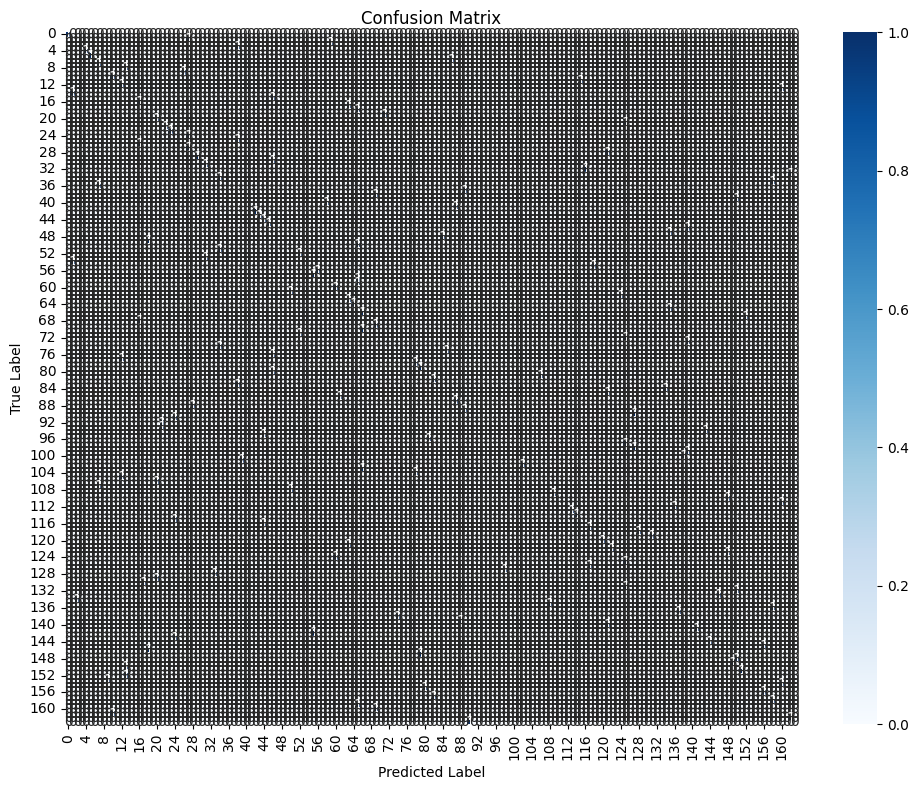

In [ ]:
import torch
from torch import nn
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_loader, criterion, device='cuda'):
    """
    Evaluate the model on test data

    Args:
        model (nn.Module): The trained model
        test_loader (DataLoader): DataLoader containing test data
        criterion (nn.Module): Loss function
        device (str): Device to run evaluation on ('cuda' or 'cpu')

    Returns:
        dict: Dictionary containing evaluation metrics
    """
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            # Get batch data
            sequences = batch['sequence'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            person_ids = batch['person_id'].to(device)

            # Forward pass
            outputs = model(sequences, attention_mask)
            loss = criterion(outputs, person_ids)

            # Calculate predictions
            predictions = torch.argmax(outputs, dim=1)

            # Accumulate results
            total_loss += loss.item()
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(person_ids.cpu().numpy())

    # Calculate metrics
    avg_loss = total_loss / len(test_loader)
    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Get detailed classification report
    report = classification_report(all_labels, all_predictions, output_dict=True)

    return {
        'test_loss': avg_loss,
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report,
        'predictions': all_predictions,
        'true_labels': all_labels
    }

def plot_confusion_matrix(confusion_matrix, class_names=None):
    """
    Plot confusion matrix as a heatmap

    Args:
        confusion_matrix (np.ndarray): The confusion matrix to plot
        class_names (list, optional): List of class names
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    if class_names:
        plt.xticks(np.arange(len(class_names)) + 0.5, class_names, rotation=45)
        plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=45)
    plt.tight_layout()
    plt.show()

def print_evaluation_results(results):
    """
    Print evaluation metrics in a formatted way

    Args:
        results (dict): Dictionary containing evaluation results
    """
    print("\nEvaluation Results:")
    print(f"Test Loss: {results['test_loss']:.4f}")
    print(f"Accuracy: {results['accuracy']*100:.2f}%")

    print("\nDetailed Classification Report:")
    # Print per-class metrics
    for class_id in results['classification_report'].keys():
        if class_id not in ['accuracy', 'macro avg', 'weighted avg']:
            metrics = results['classification_report'][class_id]
            print(f"\nClass {class_id}:")
            print(f"Precision: {metrics['precision']:.3f}")
            print(f"Recall: {metrics['recall']:.3f}")
            print(f"F1-Score: {metrics['f1-score']:.3f}")
            print(f"Support: {metrics['support']}")

    print("\nOverall Metrics:")
    macro_avg = results['classification_report']['macro avg']
    print(f"Macro Avg - Precision: {macro_avg['precision']:.3f}, "
          f"Recall: {macro_avg['recall']:.3f}, "
          f"F1-Score: {macro_avg['precision']:.3f}")

# Example usage:
# Initialize model and move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = YourModel().to(device)
criterion = nn.CrossEntropyLoss()

# Evaluate model
results = evaluate_model(model, test_loader, criterion, device)

# Print results
print_evaluation_results(results)

# Plot confusion matrix
plot_confusion_matrix(results['confusion_matrix'])

In [ ]:
trainer.train(
    num_epochs=100,
    resume_path=None  # Set to checkpoint path to resume training
)

Training: 100%|██████████| 16/16 [00:06<00:00,  3.19it/s, loss=0.6076, accuracy=0.8158]
                                                                                       
Training Progress:   1%|          | 1/100 [00:07<13:01,  7.89s/it, train_acc=0.8158, val_acc=0.3780]


Epoch 1/100
train_cls_loss: 0.7469
train_accuracy: 0.8158
val_loss: 3.2645
val_accuracy: 0.3780




Training: 100%|██████████| 16/16 [00:06<00:00,  2.62it/s, loss=1.2721, accuracy=0.8178]
                                                                                       
Training Progress:   2%|▏         | 2/100 [00:16<13:30,  8.27s/it, train_acc=0.8178, val_acc=0.3720]


Epoch 2/100
train_cls_loss: 0.7810
train_accuracy: 0.8178
val_loss: 3.3346
val_accuracy: 0.3720




Training: 100%|██████████| 16/16 [00:05<00:00,  3.15it/s, loss=0.4952, accuracy=0.7976]
                                                                                       
Training Progress:   3%|▎         | 3/100 [00:23<12:47,  7.91s/it, train_acc=0.7976, val_acc=0.3415]


Epoch 3/100
train_cls_loss: 0.7597
train_accuracy: 0.7976
val_loss: 3.3886
val_accuracy: 0.3415




Training: 100%|██████████| 16/16 [00:06<00:00,  3.17it/s, loss=0.6338, accuracy=0.8198]
                                                                                       
Training Progress:   4%|▍         | 4/100 [00:32<13:03,  8.16s/it, train_acc=0.8198, val_acc=0.3841]


Epoch 4/100
train_cls_loss: 0.7320
train_accuracy: 0.8198
val_loss: 3.1659
val_accuracy: 0.3841




Training: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s, loss=0.8673, accuracy=0.8259]
                                                                                       
Training Progress:   5%|▌         | 5/100 [00:40<13:07,  8.29s/it, train_acc=0.8259, val_acc=0.3537]


Epoch 5/100
train_cls_loss: 0.7075
train_accuracy: 0.8259
val_loss: 3.2559
val_accuracy: 0.3537




Training: 100%|██████████| 16/16 [00:05<00:00,  3.16it/s, loss=1.1647, accuracy=0.8543]
                                                                                       
Training Progress:   6%|▌         | 6/100 [00:48<12:36,  8.05s/it, train_acc=0.8543, val_acc=0.3841]


Epoch 6/100
train_cls_loss: 0.6765
train_accuracy: 0.8543
val_loss: 3.2576
val_accuracy: 0.3841




Training: 100%|██████████| 16/16 [00:06<00:00,  2.81it/s, loss=0.7044, accuracy=0.8482]
                                                                                       
Training Progress:   7%|▋         | 7/100 [00:57<12:44,  8.22s/it, train_acc=0.8482, val_acc=0.3780]


Epoch 7/100
train_cls_loss: 0.6666
train_accuracy: 0.8482
val_loss: 3.2547
val_accuracy: 0.3780




Training: 100%|██████████| 16/16 [00:06<00:00,  2.61it/s, loss=0.5772, accuracy=0.8563]
                                                                                       
Training Progress:   8%|▊         | 8/100 [01:06<12:57,  8.45s/it, train_acc=0.8563, val_acc=0.3902]


Epoch 8/100
train_cls_loss: 0.6293
train_accuracy: 0.8563
val_loss: 3.3173
val_accuracy: 0.3902




Training: 100%|██████████| 16/16 [00:05<00:00,  3.10it/s, loss=0.6949, accuracy=0.8421]
                                                                                       
Training Progress:   9%|▉         | 9/100 [01:13<12:23,  8.17s/it, train_acc=0.8421, val_acc=0.3720]


Epoch 9/100
train_cls_loss: 0.6438
train_accuracy: 0.8421
val_loss: 3.1568
val_accuracy: 0.3720




Training: 100%|██████████| 16/16 [00:06<00:00,  2.92it/s, loss=0.6146, accuracy=0.8279]
                                                                                       
Training Progress:  10%|█         | 10/100 [01:22<12:25,  8.29s/it, train_acc=0.8279, val_acc=0.3598]


Epoch 10/100
train_cls_loss: 0.6376
train_accuracy: 0.8279
val_loss: 3.3649
val_accuracy: 0.3598




Training: 100%|██████████| 16/16 [00:06<00:00,  3.07it/s, loss=0.7977, accuracy=0.8279]
                                                                                       
Training Progress:  11%|█         | 11/100 [01:30<12:14,  8.26s/it, train_acc=0.8279, val_acc=0.3415]


Epoch 11/100
train_cls_loss: 0.6612
train_accuracy: 0.8279
val_loss: 3.4640
val_accuracy: 0.3415




Training: 100%|██████████| 16/16 [00:06<00:00,  2.96it/s, loss=0.4911, accuracy=0.8603]
                                                                                       
Training Progress:  12%|█▏        | 12/100 [01:38<12:05,  8.25s/it, train_acc=0.8603, val_acc=0.3476]


Epoch 12/100
train_cls_loss: 0.6269
train_accuracy: 0.8603
val_loss: 3.3239
val_accuracy: 0.3476




Training: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s, loss=0.9933, accuracy=0.8482]
                                                                                       
Training Progress:  13%|█▎        | 13/100 [01:47<12:06,  8.35s/it, train_acc=0.8482, val_acc=0.3537]


Epoch 13/100
train_cls_loss: 0.6473
train_accuracy: 0.8482
val_loss: 3.3981
val_accuracy: 0.3537




Training: 100%|██████████| 16/16 [00:06<00:00,  3.12it/s, loss=0.3787, accuracy=0.8421]
                                                                                       
Training Progress:  14%|█▍        | 14/100 [01:54<11:41,  8.16s/it, train_acc=0.8421, val_acc=0.3598]


Epoch 14/100
train_cls_loss: 0.6107
train_accuracy: 0.8421
val_loss: 3.3267
val_accuracy: 0.3598




Training: 100%|██████████| 16/16 [00:06<00:00,  3.09it/s, loss=0.5859, accuracy=0.8968]
                                                                                       
Training Progress:  15%|█▌        | 15/100 [02:03<11:41,  8.26s/it, train_acc=0.8968, val_acc=0.3598]


Epoch 15/100
train_cls_loss: 0.5204
train_accuracy: 0.8968
val_loss: 3.3556
val_accuracy: 0.3598




Training: 100%|██████████| 16/16 [00:06<00:00,  2.42it/s, loss=0.7614, accuracy=0.8765]
                                                                                       
Training Progress:  16%|█▌        | 16/100 [02:11<11:37,  8.31s/it, train_acc=0.8765, val_acc=0.3720]


Epoch 16/100
train_cls_loss: 0.5740
train_accuracy: 0.8765
val_loss: 3.2876
val_accuracy: 0.3720




Training: 100%|██████████| 16/16 [00:05<00:00,  3.10it/s, loss=0.7975, accuracy=0.9008]
                                                                                       
Training Progress:  17%|█▋        | 17/100 [02:19<11:12,  8.10s/it, train_acc=0.9008, val_acc=0.3963]


Epoch 17/100
train_cls_loss: 0.5195
train_accuracy: 0.9008
val_loss: 3.3050
val_accuracy: 0.3963




Training: 100%|██████████| 16/16 [00:06<00:00,  3.01it/s, loss=0.8070, accuracy=0.8401]
                                                                                       
Training Progress:  18%|█▊        | 18/100 [02:28<11:26,  8.37s/it, train_acc=0.8401, val_acc=0.3780]


Epoch 18/100
train_cls_loss: 0.6156
train_accuracy: 0.8401
val_loss: 3.3980
val_accuracy: 0.3780




Training: 100%|██████████| 16/16 [00:07<00:00,  2.32it/s, loss=0.3593, accuracy=0.8765]
                                                                                       
Training Progress:  19%|█▉        | 19/100 [02:37<11:42,  8.67s/it, train_acc=0.8765, val_acc=0.3476]


Epoch 19/100
train_cls_loss: 0.5581
train_accuracy: 0.8765
val_loss: 3.3613
val_accuracy: 0.3476




Training: 100%|██████████| 16/16 [00:06<00:00,  3.14it/s, loss=0.3682, accuracy=0.8725]
                                                                                       
Training Progress:  20%|██        | 20/100 [02:45<11:15,  8.44s/it, train_acc=0.8725, val_acc=0.3659]


Epoch 20/100
train_cls_loss: 0.5506
train_accuracy: 0.8725
val_loss: 3.3915
val_accuracy: 0.3659




Training: 100%|██████████| 16/16 [00:06<00:00,  2.93it/s, loss=0.6007, accuracy=0.8826]
                                                                                       
Training Progress:  21%|██        | 21/100 [02:54<11:11,  8.50s/it, train_acc=0.8826, val_acc=0.3780]


Epoch 21/100
train_cls_loss: 0.5328
train_accuracy: 0.8826
val_loss: 3.3795
val_accuracy: 0.3780




Training: 100%|██████████| 16/16 [00:06<00:00,  2.68it/s, loss=0.4343, accuracy=0.8846]
                                                                                       
Training Progress:  22%|██▏       | 22/100 [03:02<11:06,  8.55s/it, train_acc=0.8846, val_acc=0.3780]


Epoch 22/100
train_cls_loss: 0.5211
train_accuracy: 0.8846
val_loss: 3.3514
val_accuracy: 0.3780




Training: 100%|██████████| 16/16 [00:06<00:00,  2.94it/s, loss=0.3612, accuracy=0.8866]
                                                                                       
Training Progress:  23%|██▎       | 23/100 [03:10<10:41,  8.33s/it, train_acc=0.8866, val_acc=0.3659]


Epoch 23/100
train_cls_loss: 0.5120
train_accuracy: 0.8866
val_loss: 3.3721
val_accuracy: 0.3659




Training: 100%|██████████| 16/16 [00:06<00:00,  2.88it/s, loss=0.4608, accuracy=0.8968]
                                                                                       
Training Progress:  24%|██▍       | 24/100 [03:19<10:40,  8.42s/it, train_acc=0.8968, val_acc=0.3780]


Epoch 24/100
train_cls_loss: 0.4721
train_accuracy: 0.8968
val_loss: 3.2768
val_accuracy: 0.3780




Training: 100%|██████████| 16/16 [00:05<00:00,  3.11it/s, loss=0.4738, accuracy=0.8866]
                                                                                       
Training Progress:  25%|██▌       | 25/100 [03:27<10:32,  8.43s/it, train_acc=0.8866, val_acc=0.3659]


Epoch 25/100
train_cls_loss: 0.4959
train_accuracy: 0.8866
val_loss: 3.3180
val_accuracy: 0.3659




Training: 100%|██████████| 16/16 [00:06<00:00,  3.14it/s, loss=0.4412, accuracy=0.8988]
                                                                                       
Training Progress:  26%|██▌       | 26/100 [03:35<10:10,  8.24s/it, train_acc=0.8988, val_acc=0.3780]


Epoch 26/100
train_cls_loss: 0.4562
train_accuracy: 0.8988
val_loss: 3.6022
val_accuracy: 0.3780




Training: 100%|██████████| 16/16 [00:06<00:00,  2.79it/s, loss=0.2122, accuracy=0.9028]
                                                                                       
Training Progress:  27%|██▋       | 27/100 [03:44<10:10,  8.37s/it, train_acc=0.9028, val_acc=0.3902]


Epoch 27/100
train_cls_loss: 0.4553
train_accuracy: 0.9028
val_loss: 3.3776
val_accuracy: 0.3902




Training: 100%|██████████| 16/16 [00:06<00:00,  3.06it/s, loss=0.3824, accuracy=0.8907]
                                                                                       
Training Progress:  28%|██▊       | 28/100 [03:52<10:00,  8.34s/it, train_acc=0.8907, val_acc=0.3415]


Epoch 28/100
train_cls_loss: 0.4861
train_accuracy: 0.8907
val_loss: 3.2999
val_accuracy: 0.3415




Training: 100%|██████████| 16/16 [00:06<00:00,  3.11it/s, loss=0.3983, accuracy=0.8826]
                                                                                       
Training Progress:  29%|██▉       | 29/100 [04:00<09:48,  8.29s/it, train_acc=0.8826, val_acc=0.3659]


Epoch 29/100
train_cls_loss: 0.4861
train_accuracy: 0.8826
val_loss: 3.4890
val_accuracy: 0.3659




Training: 100%|██████████| 16/16 [00:06<00:00,  2.56it/s, loss=0.2400, accuracy=0.9049]
                                                                                       
Training Progress:  30%|███       | 30/100 [04:09<09:47,  8.39s/it, train_acc=0.9049, val_acc=0.3720]


Epoch 30/100
train_cls_loss: 0.4483
train_accuracy: 0.9049
val_loss: 3.3852
val_accuracy: 0.3720




Training: 100%|██████████| 16/16 [00:06<00:00,  2.95it/s, loss=0.6992, accuracy=0.9089]
                                                                                       
Training Progress:  31%|███       | 31/100 [04:17<09:31,  8.28s/it, train_acc=0.9089, val_acc=0.3780]


Epoch 31/100
train_cls_loss: 0.4460
train_accuracy: 0.9089
val_loss: 3.3979
val_accuracy: 0.3780




Training: 100%|██████████| 16/16 [00:06<00:00,  2.96it/s, loss=0.6310, accuracy=0.8907]
                                                                                       
Training Progress:  32%|███▏      | 32/100 [04:26<09:31,  8.40s/it, train_acc=0.8907, val_acc=0.3963]


Epoch 32/100
train_cls_loss: 0.4900
train_accuracy: 0.8907
val_loss: 3.3906
val_accuracy: 0.3963




Training: 100%|██████████| 16/16 [00:07<00:00,  2.46it/s, loss=0.4893, accuracy=0.8988]
                                                                                       
Training Progress:  33%|███▎      | 33/100 [04:34<09:28,  8.49s/it, train_acc=0.8988, val_acc=0.3659]


Epoch 33/100
train_cls_loss: 0.4548
train_accuracy: 0.8988
val_loss: 3.5351
val_accuracy: 0.3659




Training: 100%|██████████| 16/16 [00:06<00:00,  3.01it/s, loss=0.2689, accuracy=0.8826]
                                                                                       
Training Progress:  34%|███▍      | 34/100 [04:42<09:05,  8.27s/it, train_acc=0.8826, val_acc=0.3720]


Epoch 34/100
train_cls_loss: 0.4628
train_accuracy: 0.8826
val_loss: 3.4557
val_accuracy: 0.3720




Training: 100%|██████████| 16/16 [00:07<00:00,  3.01it/s, loss=0.4168, accuracy=0.8927]
                                                                                       
Training Progress:  35%|███▌      | 35/100 [04:51<09:09,  8.45s/it, train_acc=0.8927, val_acc=0.3902]


Epoch 35/100
train_cls_loss: 0.4508
train_accuracy: 0.8927
val_loss: 3.4501
val_accuracy: 0.3902




Training: 100%|██████████| 16/16 [00:06<00:00,  2.28it/s, loss=0.6107, accuracy=0.8927]
                                                                                       
Training Progress:  36%|███▌      | 36/100 [05:00<09:06,  8.55s/it, train_acc=0.8927, val_acc=0.3720]


Epoch 36/100
train_cls_loss: 0.4779
train_accuracy: 0.8927
val_loss: 3.4577
val_accuracy: 0.3720




Training: 100%|██████████| 16/16 [00:06<00:00,  3.02it/s, loss=0.7657, accuracy=0.9089]
                                                                                       
Training Progress:  37%|███▋      | 37/100 [05:08<08:45,  8.34s/it, train_acc=0.9089, val_acc=0.3902]


Epoch 37/100
train_cls_loss: 0.4210
train_accuracy: 0.9089
val_loss: 3.3337
val_accuracy: 0.3902




Training: 100%|██████████| 16/16 [00:07<00:00,  2.90it/s, loss=0.7394, accuracy=0.9231]
                                                                                       
Training Progress:  38%|███▊      | 38/100 [05:16<08:44,  8.46s/it, train_acc=0.9231, val_acc=0.3720]


Epoch 38/100
train_cls_loss: 0.4074
train_accuracy: 0.9231
val_loss: 3.3872
val_accuracy: 0.3720




Training: 100%|██████████| 16/16 [00:06<00:00,  2.42it/s, loss=0.5929, accuracy=0.9190]
                                                                                       
Training Progress:  39%|███▉      | 39/100 [05:25<08:42,  8.57s/it, train_acc=0.9190, val_acc=0.3720]


Epoch 39/100
train_cls_loss: 0.4211
train_accuracy: 0.9190
val_loss: 3.3681
val_accuracy: 0.3720




Training: 100%|██████████| 16/16 [00:06<00:00,  3.02it/s, loss=0.2625, accuracy=0.8907]
                                                                                       
Training Progress:  40%|████      | 40/100 [05:33<08:19,  8.32s/it, train_acc=0.8907, val_acc=0.3902]


Epoch 40/100
train_cls_loss: 0.4290
train_accuracy: 0.8907
val_loss: 3.5294
val_accuracy: 0.3902




Training: 100%|██████████| 16/16 [00:08<00:00,  2.70it/s, loss=0.4419, accuracy=0.9049]
                                                                                       
Training Progress:  41%|████      | 41/100 [05:43<08:36,  8.76s/it, train_acc=0.9049, val_acc=0.3659]


Epoch 41/100
train_cls_loss: 0.4074
train_accuracy: 0.9049
val_loss: 3.4734
val_accuracy: 0.3659




Training: 100%|██████████| 16/16 [00:06<00:00,  2.94it/s, loss=0.4600, accuracy=0.9089]
                                                                                       
Training Progress:  42%|████▏     | 42/100 [05:51<08:25,  8.71s/it, train_acc=0.9089, val_acc=0.3659]


Epoch 42/100
train_cls_loss: 0.3829
train_accuracy: 0.9089
val_loss: 3.4046
val_accuracy: 0.3659




Training: 100%|██████████| 16/16 [00:06<00:00,  3.00it/s, loss=0.2472, accuracy=0.9170]
                                                                                       
Training Progress:  43%|████▎     | 43/100 [05:59<08:06,  8.54s/it, train_acc=0.9170, val_acc=0.3476]


Epoch 43/100
train_cls_loss: 0.3775
train_accuracy: 0.9170
val_loss: 3.3758
val_accuracy: 0.3476




Training: 100%|██████████| 16/16 [00:06<00:00,  2.72it/s, loss=0.2866, accuracy=0.9251]
                                                                                       
Training Progress:  44%|████▍     | 44/100 [06:08<08:00,  8.57s/it, train_acc=0.9251, val_acc=0.3659]


Epoch 44/100
train_cls_loss: 0.3609
train_accuracy: 0.9251
val_loss: 3.3900
val_accuracy: 0.3659




Training: 100%|██████████| 16/16 [00:06<00:00,  2.91it/s, loss=0.1519, accuracy=0.9251]
                                                                                       
Training Progress:  45%|████▌     | 45/100 [06:16<07:47,  8.51s/it, train_acc=0.9251, val_acc=0.3659]


Epoch 45/100
train_cls_loss: 0.3378
train_accuracy: 0.9251
val_loss: 3.3974
val_accuracy: 0.3659




Training: 100%|██████████| 16/16 [00:06<00:00,  3.02it/s, loss=0.3374, accuracy=0.9109]
                                                                                       
Training Progress:  46%|████▌     | 46/100 [06:25<07:35,  8.44s/it, train_acc=0.9109, val_acc=0.3841]


Epoch 46/100
train_cls_loss: 0.3672
train_accuracy: 0.9109
val_loss: 3.4533
val_accuracy: 0.3841




Training: 100%|██████████| 16/16 [00:06<00:00,  2.41it/s, loss=0.2261, accuracy=0.9251]
                                                                                       
Training Progress:  47%|████▋     | 47/100 [06:33<07:31,  8.53s/it, train_acc=0.9251, val_acc=0.3476]


Epoch 47/100
train_cls_loss: 0.3481
train_accuracy: 0.9251
val_loss: 3.6534
val_accuracy: 0.3476




Training: 100%|██████████| 16/16 [00:06<00:00,  2.96it/s, loss=0.3802, accuracy=0.9231]
                                                                                       
Training Progress:  48%|████▊     | 48/100 [06:41<07:11,  8.30s/it, train_acc=0.9231, val_acc=0.3902]


Epoch 48/100
train_cls_loss: 0.3235
train_accuracy: 0.9231
val_loss: 3.4506
val_accuracy: 0.3902




Training: 100%|██████████| 16/16 [00:07<00:00,  2.92it/s, loss=0.4031, accuracy=0.9453]
                                                                                       
Training Progress:  49%|████▉     | 49/100 [06:50<07:12,  8.48s/it, train_acc=0.9453, val_acc=0.3659]


Epoch 49/100
train_cls_loss: 0.2940
train_accuracy: 0.9453
val_loss: 3.6124
val_accuracy: 0.3659




Training: 100%|██████████| 16/16 [00:07<00:00,  2.16it/s, loss=0.3050, accuracy=0.9211]
                                                                                       
Training Progress:  50%|█████     | 50/100 [06:59<07:10,  8.60s/it, train_acc=0.9211, val_acc=0.3659]


Epoch 50/100
train_cls_loss: 0.3475
train_accuracy: 0.9211
val_loss: 3.6544
val_accuracy: 0.3659




Training: 100%|██████████| 16/16 [00:06<00:00,  3.07it/s, loss=0.2421, accuracy=0.9231]
                                                                                       
Training Progress:  51%|█████     | 51/100 [07:07<06:51,  8.39s/it, train_acc=0.9231, val_acc=0.3415]


Epoch 51/100
train_cls_loss: 0.3602
train_accuracy: 0.9231
val_loss: 3.6327
val_accuracy: 0.3415




Training: 100%|██████████| 16/16 [00:06<00:00,  2.97it/s, loss=0.5597, accuracy=0.9170]
                                                                                       
Training Progress:  52%|█████▏    | 52/100 [07:16<06:46,  8.48s/it, train_acc=0.9170, val_acc=0.3659]


Epoch 52/100
train_cls_loss: 0.3545
train_accuracy: 0.9170
val_loss: 3.5916
val_accuracy: 0.3659




Training: 100%|██████████| 16/16 [00:06<00:00,  2.28it/s, loss=0.4137, accuracy=0.9190]
                                                                                       
Training Progress:  53%|█████▎    | 53/100 [07:24<06:40,  8.52s/it, train_acc=0.9190, val_acc=0.3780]


Epoch 53/100
train_cls_loss: 0.3199
train_accuracy: 0.9190
val_loss: 3.4845
val_accuracy: 0.3780




Training: 100%|██████████| 16/16 [00:06<00:00,  2.94it/s, loss=0.1291, accuracy=0.9211]
                                                                                       
Training Progress:  54%|█████▍    | 54/100 [07:32<06:22,  8.32s/it, train_acc=0.9211, val_acc=0.3780]


Epoch 54/100
train_cls_loss: 0.3387
train_accuracy: 0.9211
val_loss: 3.6472
val_accuracy: 0.3780




Training: 100%|██████████| 16/16 [00:06<00:00,  2.92it/s, loss=0.2534, accuracy=0.9211]
                                                                                       
Training Progress:  55%|█████▌    | 55/100 [07:41<06:18,  8.41s/it, train_acc=0.9211, val_acc=0.3476]


Epoch 55/100
train_cls_loss: 0.3210
train_accuracy: 0.9211
val_loss: 3.5211
val_accuracy: 0.3476




Training: 100%|██████████| 16/16 [00:06<00:00,  2.31it/s, loss=0.3963, accuracy=0.9251]
                                                                                       
Training Progress:  56%|█████▌    | 56/100 [07:49<06:14,  8.50s/it, train_acc=0.9251, val_acc=0.3720]


Epoch 56/100
train_cls_loss: 0.3448
train_accuracy: 0.9251
val_loss: 3.5113
val_accuracy: 0.3720




Training: 100%|██████████| 16/16 [00:06<00:00,  3.02it/s, loss=0.3139, accuracy=0.9211]
                                                                                       
Training Progress:  57%|█████▋    | 57/100 [07:57<05:58,  8.34s/it, train_acc=0.9211, val_acc=0.3537]


Epoch 57/100
train_cls_loss: 0.3430
train_accuracy: 0.9211
val_loss: 3.6335
val_accuracy: 0.3537




Training: 100%|██████████| 16/16 [00:07<00:00,  2.90it/s, loss=0.1876, accuracy=0.9433]
                                                                                       
Training Progress:  58%|█████▊    | 58/100 [08:06<05:55,  8.46s/it, train_acc=0.9433, val_acc=0.3963]


Epoch 58/100
train_cls_loss: 0.3017
train_accuracy: 0.9433
val_loss: 3.3585
val_accuracy: 0.3963




Training: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s, loss=0.3723, accuracy=0.9170]
                                                                                       
Training Progress:  59%|█████▉    | 59/100 [08:15<05:53,  8.61s/it, train_acc=0.9170, val_acc=0.3902]


Epoch 59/100
train_cls_loss: 0.3695
train_accuracy: 0.9170
val_loss: 3.3239
val_accuracy: 0.3902




Training: 100%|██████████| 16/16 [00:06<00:00,  2.85it/s, loss=0.1729, accuracy=0.9372]
                                                                                       
Training Progress:  60%|██████    | 60/100 [08:23<05:37,  8.45s/it, train_acc=0.9372, val_acc=0.3902]


Epoch 60/100
train_cls_loss: 0.3069
train_accuracy: 0.9372
val_loss: 3.5753
val_accuracy: 0.3902




Training: 100%|██████████| 16/16 [00:07<00:00,  2.92it/s, loss=0.3242, accuracy=0.9130]
                                                                                       
Training Progress:  61%|██████    | 61/100 [08:32<05:34,  8.57s/it, train_acc=0.9130, val_acc=0.3902]


Epoch 61/100
train_cls_loss: 0.3350
train_accuracy: 0.9130
val_loss: 3.5472
val_accuracy: 0.3902




Training: 100%|██████████| 16/16 [00:06<00:00,  2.53it/s, loss=0.5457, accuracy=0.9211]
                                                                                       
Training Progress:  62%|██████▏   | 62/100 [08:41<05:31,  8.72s/it, train_acc=0.9211, val_acc=0.4024]


Epoch 62/100
train_cls_loss: 0.3222
train_accuracy: 0.9211
val_loss: 3.4998
val_accuracy: 0.4024




Training: 100%|██████████| 16/16 [00:07<00:00,  2.79it/s, loss=0.3078, accuracy=0.9211]
                                                                                       
Training Progress:  63%|██████▎   | 63/100 [08:50<05:25,  8.79s/it, train_acc=0.9211, val_acc=0.3841]


Epoch 63/100
train_cls_loss: 0.3627
train_accuracy: 0.9211
val_loss: 3.4197
val_accuracy: 0.3841




Training: 100%|██████████| 16/16 [00:07<00:00,  2.87it/s, loss=0.4048, accuracy=0.9514]
                                                                                       
Training Progress:  64%|██████▍   | 64/100 [08:59<05:16,  8.80s/it, train_acc=0.9514, val_acc=0.3720]


Epoch 64/100
train_cls_loss: 0.3103
train_accuracy: 0.9514
val_loss: 3.4538
val_accuracy: 0.3720




Training: 100%|██████████| 16/16 [00:06<00:00,  2.50it/s, loss=0.7404, accuracy=0.9251]
                                                                                       
Training Progress:  65%|██████▌   | 65/100 [09:08<05:10,  8.88s/it, train_acc=0.9251, val_acc=0.3963]


Epoch 65/100
train_cls_loss: 0.3239
train_accuracy: 0.9251
val_loss: 3.4412
val_accuracy: 0.3963




Training: 100%|██████████| 16/16 [00:06<00:00,  2.94it/s, loss=0.2799, accuracy=0.9049]
                                                                                       
Training Progress:  66%|██████▌   | 66/100 [09:16<04:52,  8.61s/it, train_acc=0.9049, val_acc=0.3659]


Epoch 66/100
train_cls_loss: 0.3378
train_accuracy: 0.9049
val_loss: 3.5142
val_accuracy: 0.3659




Training: 100%|██████████| 16/16 [00:07<00:00,  2.82it/s, loss=0.2829, accuracy=0.9211]
                                                                                       
Training Progress:  67%|██████▋   | 67/100 [09:25<04:46,  8.69s/it, train_acc=0.9211, val_acc=0.3963]


Epoch 67/100
train_cls_loss: 0.3081
train_accuracy: 0.9211
val_loss: 3.6067
val_accuracy: 0.3963




Training: 100%|██████████| 16/16 [00:06<00:00,  2.71it/s, loss=0.1026, accuracy=0.9453]
                                                                                       
Training Progress:  68%|██████▊   | 68/100 [09:34<04:40,  8.78s/it, train_acc=0.9453, val_acc=0.3780]


Epoch 68/100
train_cls_loss: 0.2706
train_accuracy: 0.9453
val_loss: 3.5545
val_accuracy: 0.3780




Training: 100%|██████████| 16/16 [00:06<00:00,  3.04it/s, loss=0.2028, accuracy=0.9595]
                                                                                       
Training Progress:  69%|██████▉   | 69/100 [09:42<04:24,  8.53s/it, train_acc=0.9595, val_acc=0.3963]


Epoch 69/100
train_cls_loss: 0.2390
train_accuracy: 0.9595
val_loss: 3.4853
val_accuracy: 0.3963




Training: 100%|██████████| 16/16 [00:07<00:00,  2.71it/s, loss=0.5469, accuracy=0.9393]
                                                                                       
Training Progress:  70%|███████   | 70/100 [09:51<04:20,  8.67s/it, train_acc=0.9393, val_acc=0.4085]


Epoch 70/100
train_cls_loss: 0.2895
train_accuracy: 0.9393
val_loss: 3.5853
val_accuracy: 0.4085
New best model!




Training: 100%|██████████| 16/16 [00:06<00:00,  3.04it/s, loss=0.1701, accuracy=0.9413]
                                                                                       
Training Progress:  71%|███████   | 71/100 [09:59<04:12,  8.70s/it, train_acc=0.9413, val_acc=0.4146]


Epoch 71/100
train_cls_loss: 0.2627
train_accuracy: 0.9413
val_loss: 3.4874
val_accuracy: 0.4146
New best model!




Training: 100%|██████████| 16/16 [00:06<00:00,  2.73it/s, loss=0.2219, accuracy=0.9555]
                                                                                       
Training Progress:  72%|███████▏  | 72/100 [10:08<04:01,  8.62s/it, train_acc=0.9555, val_acc=0.4146]


Epoch 72/100
train_cls_loss: 0.2418
train_accuracy: 0.9555
val_loss: 3.4601
val_accuracy: 0.4146




Training: 100%|██████████| 16/16 [00:07<00:00,  2.70it/s, loss=0.3004, accuracy=0.9534]
                                                                                       
Training Progress:  73%|███████▎  | 73/100 [10:17<03:57,  8.79s/it, train_acc=0.9534, val_acc=0.4085]


Epoch 73/100
train_cls_loss: 0.2321
train_accuracy: 0.9534
val_loss: 3.5307
val_accuracy: 0.4085




Training: 100%|██████████| 16/16 [00:06<00:00,  2.98it/s, loss=0.3334, accuracy=0.9393]
                                                                                       
Training Progress:  74%|███████▍  | 74/100 [10:26<03:48,  8.78s/it, train_acc=0.9393, val_acc=0.3902]


Epoch 74/100
train_cls_loss: 0.2569
train_accuracy: 0.9393
val_loss: 3.6195
val_accuracy: 0.3902




Training: 100%|██████████| 16/16 [00:06<00:00,  2.94it/s, loss=0.2374, accuracy=0.9494]
                                                                                       
Training Progress:  75%|███████▌  | 75/100 [10:34<03:35,  8.63s/it, train_acc=0.9494, val_acc=0.4146]


Epoch 75/100
train_cls_loss: 0.2569
train_accuracy: 0.9494
val_loss: 3.4763
val_accuracy: 0.4146




Training: 100%|██████████| 16/16 [00:07<00:00,  2.70it/s, loss=0.2471, accuracy=0.9393]
                                                                                       
Training Progress:  76%|███████▌  | 76/100 [10:43<03:29,  8.73s/it, train_acc=0.9393, val_acc=0.4085]


Epoch 76/100
train_cls_loss: 0.2361
train_accuracy: 0.9393
val_loss: 3.5965
val_accuracy: 0.4085




Training: 100%|██████████| 16/16 [00:06<00:00,  2.95it/s, loss=0.0773, accuracy=0.9453]
                                                                                       
Training Progress:  77%|███████▋  | 77/100 [10:52<03:21,  8.74s/it, train_acc=0.9453, val_acc=0.4085]


Epoch 77/100
train_cls_loss: 0.2237
train_accuracy: 0.9453
val_loss: 3.6226
val_accuracy: 0.4085




Training: 100%|██████████| 16/16 [00:06<00:00,  3.02it/s, loss=0.2768, accuracy=0.9615]
                                                                                       
Training Progress:  78%|███████▊  | 78/100 [11:00<03:10,  8.64s/it, train_acc=0.9615, val_acc=0.4146]


Epoch 78/100
train_cls_loss: 0.2249
train_accuracy: 0.9615
val_loss: 3.5382
val_accuracy: 0.4146




Training: 100%|██████████| 16/16 [00:07<00:00,  2.56it/s, loss=0.1297, accuracy=0.9656]
                                                                                       
Training Progress:  79%|███████▉  | 79/100 [11:09<03:03,  8.75s/it, train_acc=0.9656, val_acc=0.3902]


Epoch 79/100
train_cls_loss: 0.2143
train_accuracy: 0.9656
val_loss: 3.7239
val_accuracy: 0.3902




Training: 100%|██████████| 16/16 [00:06<00:00,  2.93it/s, loss=0.2049, accuracy=0.9393]
                                                                                       
Training Progress:  80%|████████  | 80/100 [11:18<02:53,  8.69s/it, train_acc=0.9393, val_acc=0.4024]


Epoch 80/100
train_cls_loss: 0.2251
train_accuracy: 0.9393
val_loss: 3.5140
val_accuracy: 0.4024




Training: 100%|██████████| 16/16 [00:06<00:00,  2.91it/s, loss=0.1914, accuracy=0.9555]
                                                                                       
Training Progress:  81%|████████  | 81/100 [11:26<02:44,  8.65s/it, train_acc=0.9555, val_acc=0.3902]


Epoch 81/100
train_cls_loss: 0.2563
train_accuracy: 0.9555
val_loss: 3.5904
val_accuracy: 0.3902




Training: 100%|██████████| 16/16 [00:07<00:00,  2.51it/s, loss=0.3654, accuracy=0.9615]
                                                                                       
Training Progress:  82%|████████▏ | 82/100 [11:35<02:37,  8.75s/it, train_acc=0.9615, val_acc=0.3902]


Epoch 82/100
train_cls_loss: 0.2439
train_accuracy: 0.9615
val_loss: 3.5998
val_accuracy: 0.3902




Training: 100%|██████████| 16/16 [00:06<00:00,  2.97it/s, loss=0.1856, accuracy=0.9474]
                                                                                       
Training Progress:  83%|████████▎ | 83/100 [11:44<02:27,  8.66s/it, train_acc=0.9474, val_acc=0.4329]


Epoch 83/100
train_cls_loss: 0.2458
train_accuracy: 0.9474
val_loss: 3.5654
val_accuracy: 0.4329
New best model!




Training: 100%|██████████| 16/16 [00:06<00:00,  2.53it/s, loss=0.2627, accuracy=0.9251]
                                                                                       
Training Progress:  84%|████████▍ | 84/100 [11:53<02:22,  8.91s/it, train_acc=0.9251, val_acc=0.3780]


Epoch 84/100
train_cls_loss: 0.2646
train_accuracy: 0.9251
val_loss: 3.7213
val_accuracy: 0.3780




Training: 100%|██████████| 16/16 [00:07<00:00,  2.67it/s, loss=0.6253, accuracy=0.9332]
                                                                                       
Training Progress:  85%|████████▌ | 85/100 [12:02<02:14,  9.00s/it, train_acc=0.9332, val_acc=0.4024]


Epoch 85/100
train_cls_loss: 0.2902
train_accuracy: 0.9332
val_loss: 3.7631
val_accuracy: 0.4024




Training: 100%|██████████| 16/16 [00:06<00:00,  2.85it/s, loss=0.3731, accuracy=0.9474]
                                                                                       
Training Progress:  86%|████████▌ | 86/100 [12:11<02:04,  8.93s/it, train_acc=0.9474, val_acc=0.3659]


Epoch 86/100
train_cls_loss: 0.2373
train_accuracy: 0.9474
val_loss: 3.7617
val_accuracy: 0.3659




Training: 100%|██████████| 16/16 [00:06<00:00,  2.95it/s, loss=0.1024, accuracy=0.9433]
                                                                                       
Training Progress:  87%|████████▋ | 87/100 [12:19<01:53,  8.71s/it, train_acc=0.9433, val_acc=0.3720]


Epoch 87/100
train_cls_loss: 0.2454
train_accuracy: 0.9433
val_loss: 3.7284
val_accuracy: 0.3720




Training: 100%|██████████| 16/16 [00:07<00:00,  2.72it/s, loss=0.2383, accuracy=0.9413]
                                                                                       
Training Progress:  88%|████████▊ | 88/100 [12:28<01:45,  8.79s/it, train_acc=0.9413, val_acc=0.3780]


Epoch 88/100
train_cls_loss: 0.2532
train_accuracy: 0.9413
val_loss: 3.5878
val_accuracy: 0.3780




Training: 100%|██████████| 16/16 [00:06<00:00,  2.99it/s, loss=0.4540, accuracy=0.9433]
                                                                                       
Training Progress:  89%|████████▉ | 89/100 [12:37<01:36,  8.75s/it, train_acc=0.9433, val_acc=0.4207]


Epoch 89/100
train_cls_loss: 0.2388
train_accuracy: 0.9433
val_loss: 3.5463
val_accuracy: 0.4207




Training: 100%|██████████| 16/16 [00:06<00:00,  2.85it/s, loss=0.3102, accuracy=0.9453]
                                                                                       
Training Progress:  90%|█████████ | 90/100 [12:46<01:26,  8.66s/it, train_acc=0.9453, val_acc=0.3841]


Epoch 90/100
train_cls_loss: 0.2196
train_accuracy: 0.9453
val_loss: 3.7767
val_accuracy: 0.3841




Training: 100%|██████████| 16/16 [00:07<00:00,  2.67it/s, loss=0.2909, accuracy=0.9393]
                                                                                       
Training Progress:  91%|█████████ | 91/100 [12:54<01:18,  8.75s/it, train_acc=0.9393, val_acc=0.3720]


Epoch 91/100
train_cls_loss: 0.2316
train_accuracy: 0.9393
val_loss: 3.7036
val_accuracy: 0.3720




Training: 100%|██████████| 16/16 [00:06<00:00,  2.95it/s, loss=0.1598, accuracy=0.9433]
                                                                                       
Training Progress:  92%|█████████▏| 92/100 [13:03<01:09,  8.74s/it, train_acc=0.9433, val_acc=0.4146]


Epoch 92/100
train_cls_loss: 0.2319
train_accuracy: 0.9433
val_loss: 3.5393
val_accuracy: 0.4146




Training: 100%|██████████| 16/16 [00:06<00:00,  3.04it/s, loss=0.3368, accuracy=0.9474]
                                                                                       
Training Progress:  93%|█████████▎| 93/100 [13:11<01:00,  8.58s/it, train_acc=0.9474, val_acc=0.3841]


Epoch 93/100
train_cls_loss: 0.2162
train_accuracy: 0.9474
val_loss: 3.7600
val_accuracy: 0.3841




Training: 100%|██████████| 16/16 [00:07<00:00,  2.62it/s, loss=0.1292, accuracy=0.9514]
                                                                                       
Training Progress:  94%|█████████▍| 94/100 [13:20<00:52,  8.71s/it, train_acc=0.9514, val_acc=0.4024]


Epoch 94/100
train_cls_loss: 0.2006
train_accuracy: 0.9514
val_loss: 3.4585
val_accuracy: 0.4024




Training: 100%|██████████| 16/16 [00:06<00:00,  2.95it/s, loss=0.1368, accuracy=0.9636]
                                                                                       
Training Progress:  95%|█████████▌| 95/100 [13:29<00:43,  8.72s/it, train_acc=0.9636, val_acc=0.4146]


Epoch 95/100
train_cls_loss: 0.1809
train_accuracy: 0.9636
val_loss: 3.5947
val_accuracy: 0.4146




Training: 100%|██████████| 16/16 [00:06<00:00,  2.88it/s, loss=0.1025, accuracy=0.9696]
                                                                                       
Training Progress:  96%|█████████▌| 96/100 [13:38<00:34,  8.67s/it, train_acc=0.9696, val_acc=0.3598]


Epoch 96/100
train_cls_loss: 0.1559
train_accuracy: 0.9696
val_loss: 3.8127
val_accuracy: 0.3598




Training: 100%|██████████| 16/16 [00:07<00:00,  2.69it/s, loss=0.1233, accuracy=0.9656]
                                                                                       
Training Progress:  97%|█████████▋| 97/100 [13:47<00:26,  8.73s/it, train_acc=0.9656, val_acc=0.4207]


Epoch 97/100
train_cls_loss: 0.1645
train_accuracy: 0.9656
val_loss: 3.5846
val_accuracy: 0.4207




Training: 100%|██████████| 16/16 [00:06<00:00,  2.95it/s, loss=0.2612, accuracy=0.9717]
                                                                                       
Training Progress:  98%|█████████▊| 98/100 [13:55<00:17,  8.72s/it, train_acc=0.9717, val_acc=0.4146]


Epoch 98/100
train_cls_loss: 0.1648
train_accuracy: 0.9717
val_loss: 3.7672
val_accuracy: 0.4146




Training: 100%|██████████| 16/16 [00:06<00:00,  2.90it/s, loss=0.0536, accuracy=0.9514]
                                                                                       
Training Progress:  99%|█████████▉| 99/100 [14:04<00:08,  8.62s/it, train_acc=0.9514, val_acc=0.3659]


Epoch 99/100
train_cls_loss: 0.2003
train_accuracy: 0.9514
val_loss: 3.8546
val_accuracy: 0.3659




Training: 100%|██████████| 16/16 [00:07<00:00,  2.71it/s, loss=0.1603, accuracy=0.9595]
                                                                                       
Training Progress: 100%|██████████| 100/100 [14:13<00:00,  8.53s/it, train_acc=0.9595, val_acc=0.3841]


Epoch 100/100
train_cls_loss: 0.1992
train_accuracy: 0.9595
val_loss: 3.7144
val_accuracy: 0.3841



In [ ]:
torch.save(model.state_dict(),'skeleton_transformer_models/best_model_2.pt')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Evaluation Results:
Test Loss: 4.8177
Accuracy: 30.49%

Detailed Classification Report:

Class 0:
Precision: 1.000
Recall: 1.000
F1-Score: 1.000
Support: 1.0

Class 1:
Precision: 0.000
Recall: 0.000
F1-Score: 0.000
Support: 1.0

Class 2:
Precision: 0.000
Recall: 0.000
F1-Score: 0.000
Support: 1.0

Class 3:
Precision: 0.000
Recall: 0.000
F1-Score: 0.000
Support: 1.0

Class 4:
Precision: 1.000
Recall: 1.000
F1-Score: 1.000
Support: 1.0

Class 5:
Precision: 0.000
Recall: 0.000
F1-Score: 0.000
Support: 1.0

Class 6:
Precision: 0.000
Recall: 0.000
F1-Score: 0.000
Support: 1.0

Class 7:
Precision: 0.333
Recall: 1.000
F1-Score: 0.500
Support: 1.0

Class 8:
Precision: 0.000
Recall: 0.000
F1-Score: 0.000
Support: 1.0

Class 9:
Precision: 0.000
Recall: 0.000
F1-Score: 0.000
Support: 1.0

Class 10:
Precision: 0.500
Recall: 1.000
F1-Score: 0.667
Support: 1.0

Class 11:
Precision: 0.000
Recall: 0.000
F1-Score: 0.000
Support: 1.0

Class 12:
Precision: 0.500
Recall: 1.000
F1-Score: 0.667
Support: 1.

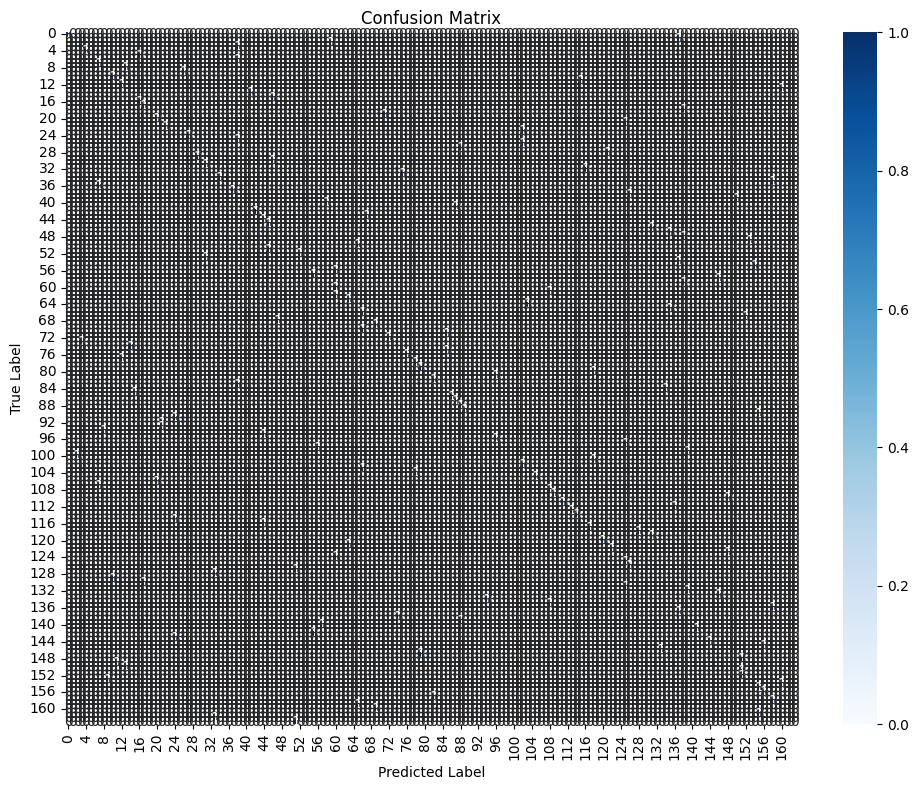

In [ ]:
import torch
from torch import nn
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_loader, criterion, device='cuda'):
    """
    Evaluate the model on test data

    Args:
        model (nn.Module): The trained model
        test_loader (DataLoader): DataLoader containing test data
        criterion (nn.Module): Loss function
        device (str): Device to run evaluation on ('cuda' or 'cpu')

    Returns:
        dict: Dictionary containing evaluation metrics
    """
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            # Get batch data
            sequences = batch['sequence'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            person_ids = batch['person_id'].to(device)

            # Forward pass
            outputs = model(sequences, attention_mask)
            loss = criterion(outputs, person_ids)

            # Calculate predictions
            predictions = torch.argmax(outputs, dim=1)

            # Accumulate results
            total_loss += loss.item()
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(person_ids.cpu().numpy())

    # Calculate metrics
    avg_loss = total_loss / len(test_loader)
    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Get detailed classification report
    report = classification_report(all_labels, all_predictions, output_dict=True)

    return {
        'test_loss': avg_loss,
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report,
        'predictions': all_predictions,
        'true_labels': all_labels
    }

def plot_confusion_matrix(confusion_matrix, class_names=None):
    """
    Plot confusion matrix as a heatmap

    Args:
        confusion_matrix (np.ndarray): The confusion matrix to plot
        class_names (list, optional): List of class names
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    if class_names:
        plt.xticks(np.arange(len(class_names)) + 0.5, class_names, rotation=45)
        plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=45)
    plt.tight_layout()
    plt.show()

def print_evaluation_results(results):
    """
    Print evaluation metrics in a formatted way

    Args:
        results (dict): Dictionary containing evaluation results
    """
    print("\nEvaluation Results:")
    print(f"Test Loss: {results['test_loss']:.4f}")
    print(f"Accuracy: {results['accuracy']*100:.2f}%")

    print("\nDetailed Classification Report:")
    # Print per-class metrics
    for class_id in results['classification_report'].keys():
        if class_id not in ['accuracy', 'macro avg', 'weighted avg']:
            metrics = results['classification_report'][class_id]
            print(f"\nClass {class_id}:")
            print(f"Precision: {metrics['precision']:.3f}")
            print(f"Recall: {metrics['recall']:.3f}")
            print(f"F1-Score: {metrics['f1-score']:.3f}")
            print(f"Support: {metrics['support']}")

    print("\nOverall Metrics:")
    macro_avg = results['classification_report']['macro avg']
    print(f"Macro Avg - Precision: {macro_avg['precision']:.3f}, "
          f"Recall: {macro_avg['recall']:.3f}, "
          f"F1-Score: {macro_avg['precision']:.3f}")

# Example usage:
# Initialize model and move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = YourModel().to(device)
criterion = nn.CrossEntropyLoss()

# Evaluate model
results = evaluate_model(model, test_loader, criterion, device)

# Print results
print_evaluation_results(results)

# Plot confusion matrix
plot_confusion_matrix(results['confusion_matrix'])